In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap
import torch
from tabulate import tabulate
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.init import kaiming_normal_
from IPython.display import clear_output

In [2]:
# # Set random seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
# Cell 2: Load and display dataset
diabetes_df = pd.read_csv('diabetes.csv')
diabetes_df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

In [4]:
print("Dataset shape ::", diabetes_df.shape)

Dataset shape :: (768, 9)


In [5]:
print("\nClass distribution:")
print(diabetes_df['Outcome'].value_counts())


Class distribution:
0    500
1    268
Name: Outcome, dtype: int64


In [6]:
feature_ranges = {col: (diabetes_df[col].min(), diabetes_df[col].max()) for col in diabetes_df}
feature_ranges

{'Pregnancies': (0, 17),
 'Glucose': (0, 199),
 'BloodPressure': (0, 122),
 'SkinThickness': (0, 99),
 'Insulin': (0, 846),
 'BMI': (0.0, 67.1),
 'DiabetesPedigreeFunction': (0.078, 2.42),
 'Age': (21, 81),
 'Outcome': (0, 1)}

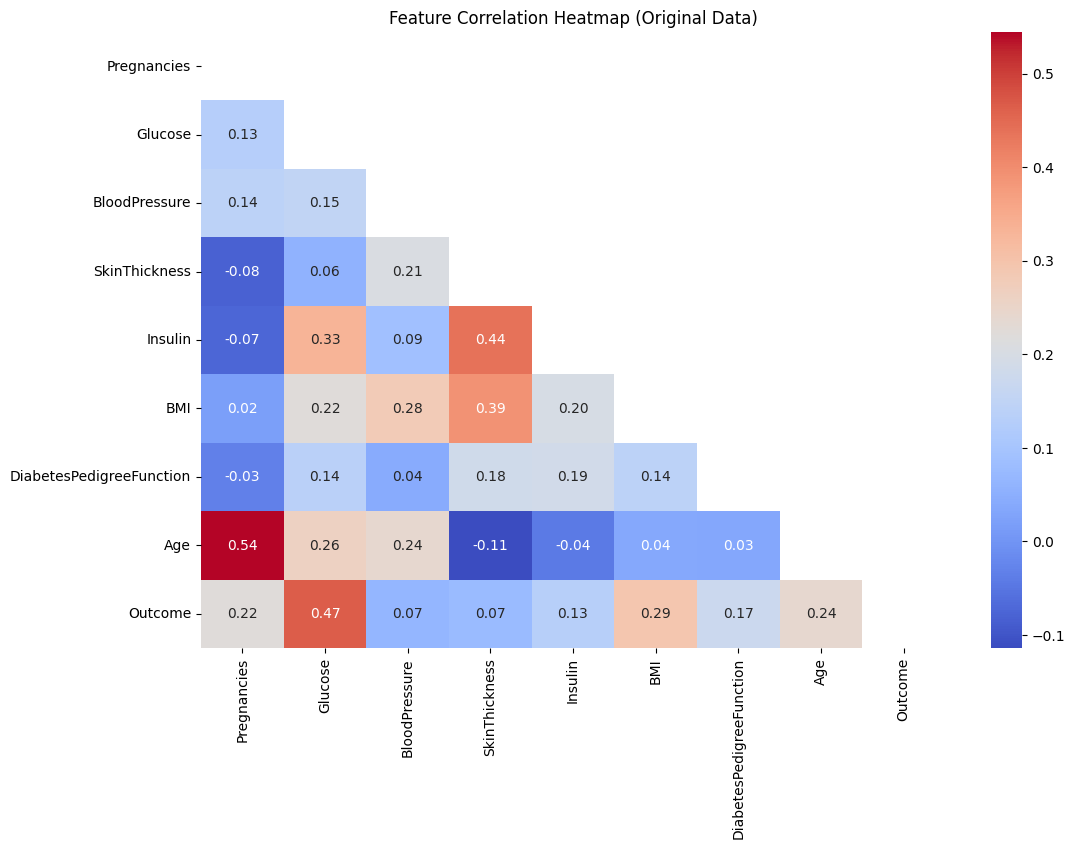

In [7]:
# Cell 3a: Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = diabetes_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", mask=np.triu(np.ones_like(corr, dtype=bool)))
plt.title('Feature Correlation Heatmap (Original Data)')
plt.show()

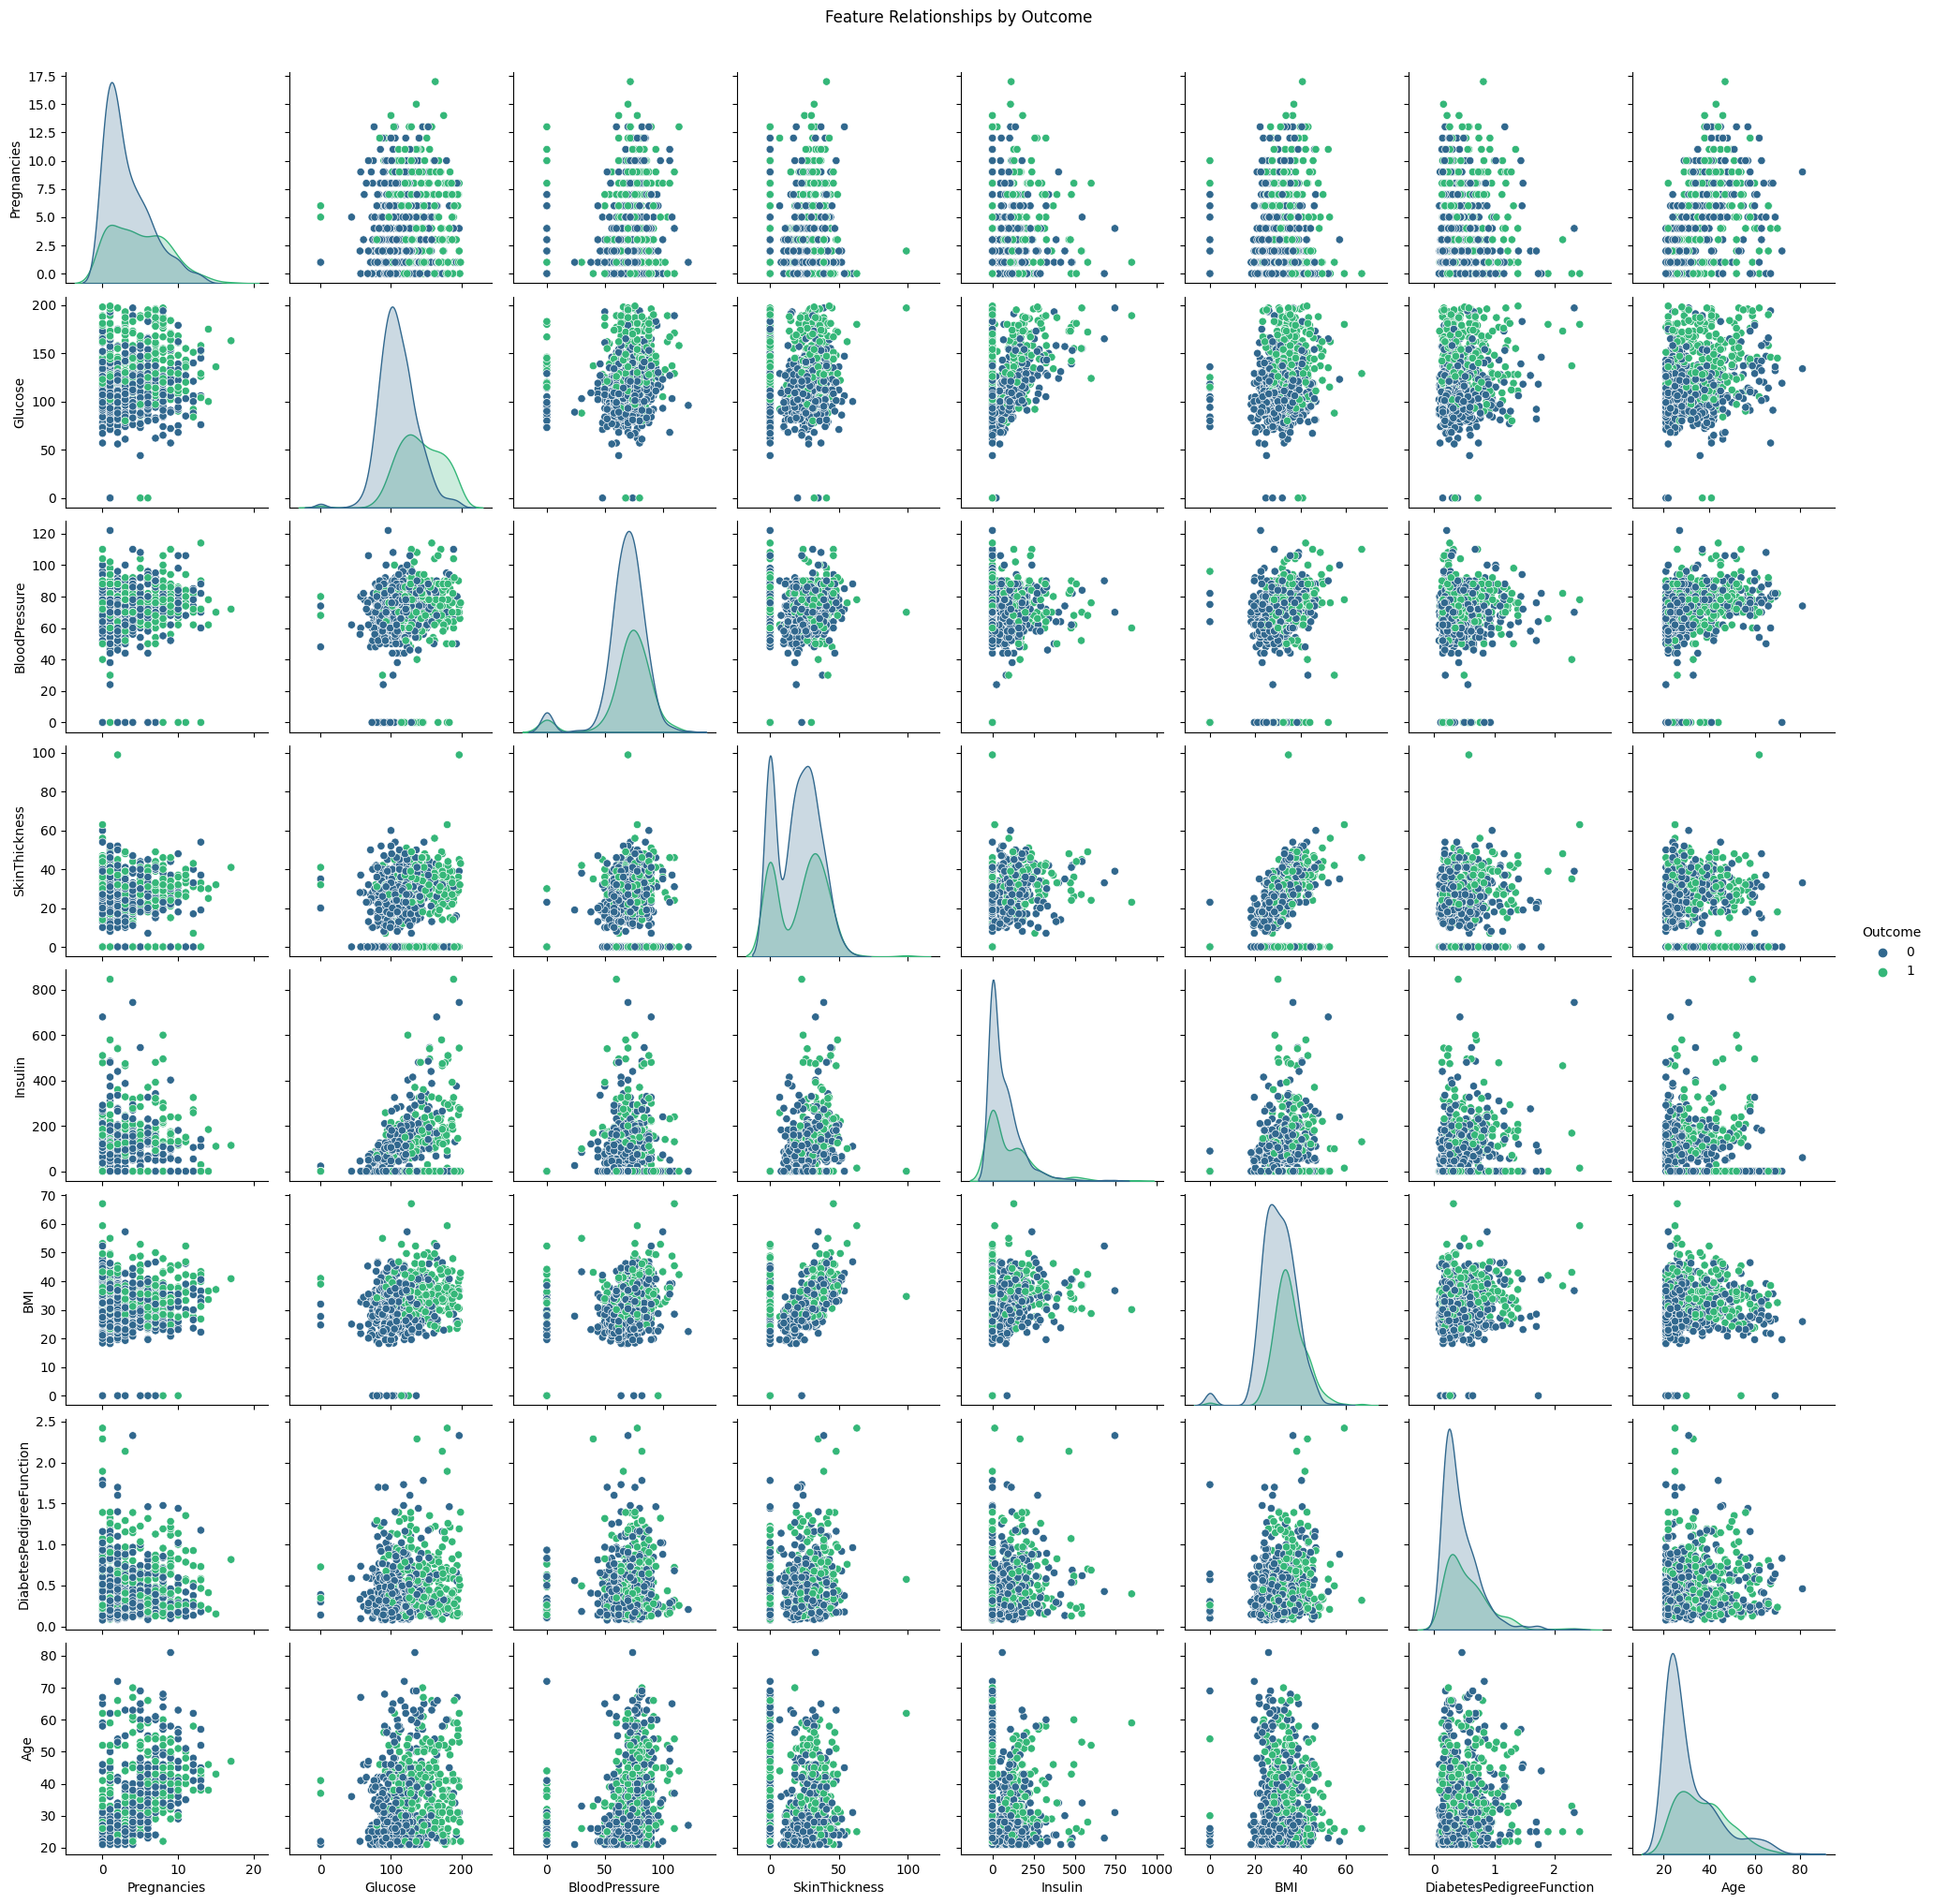

In [8]:
#Pairplot of Selected Features
sns.pairplot(diabetes_df, hue='Outcome', palette='viridis')
plt.suptitle('Feature Relationships by Outcome', y=1.02)
plt.show()

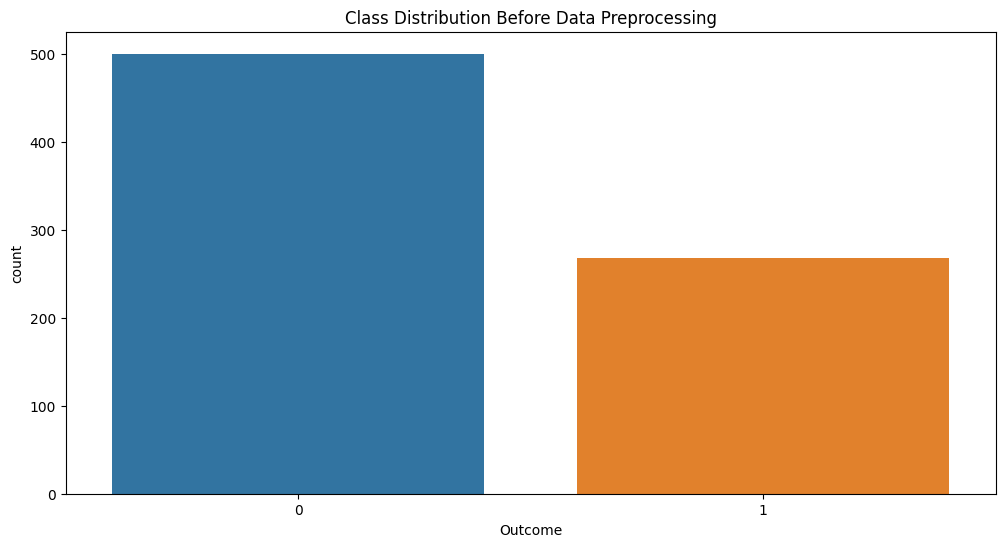

In [9]:
# Preprocessing visualization
# Before preprocessing plots
plt.figure(figsize=(12, 6))
sns.countplot(x='Outcome', data=diabetes_df)
plt.title('Class Distribution Before Data Preprocessing')
plt.show()

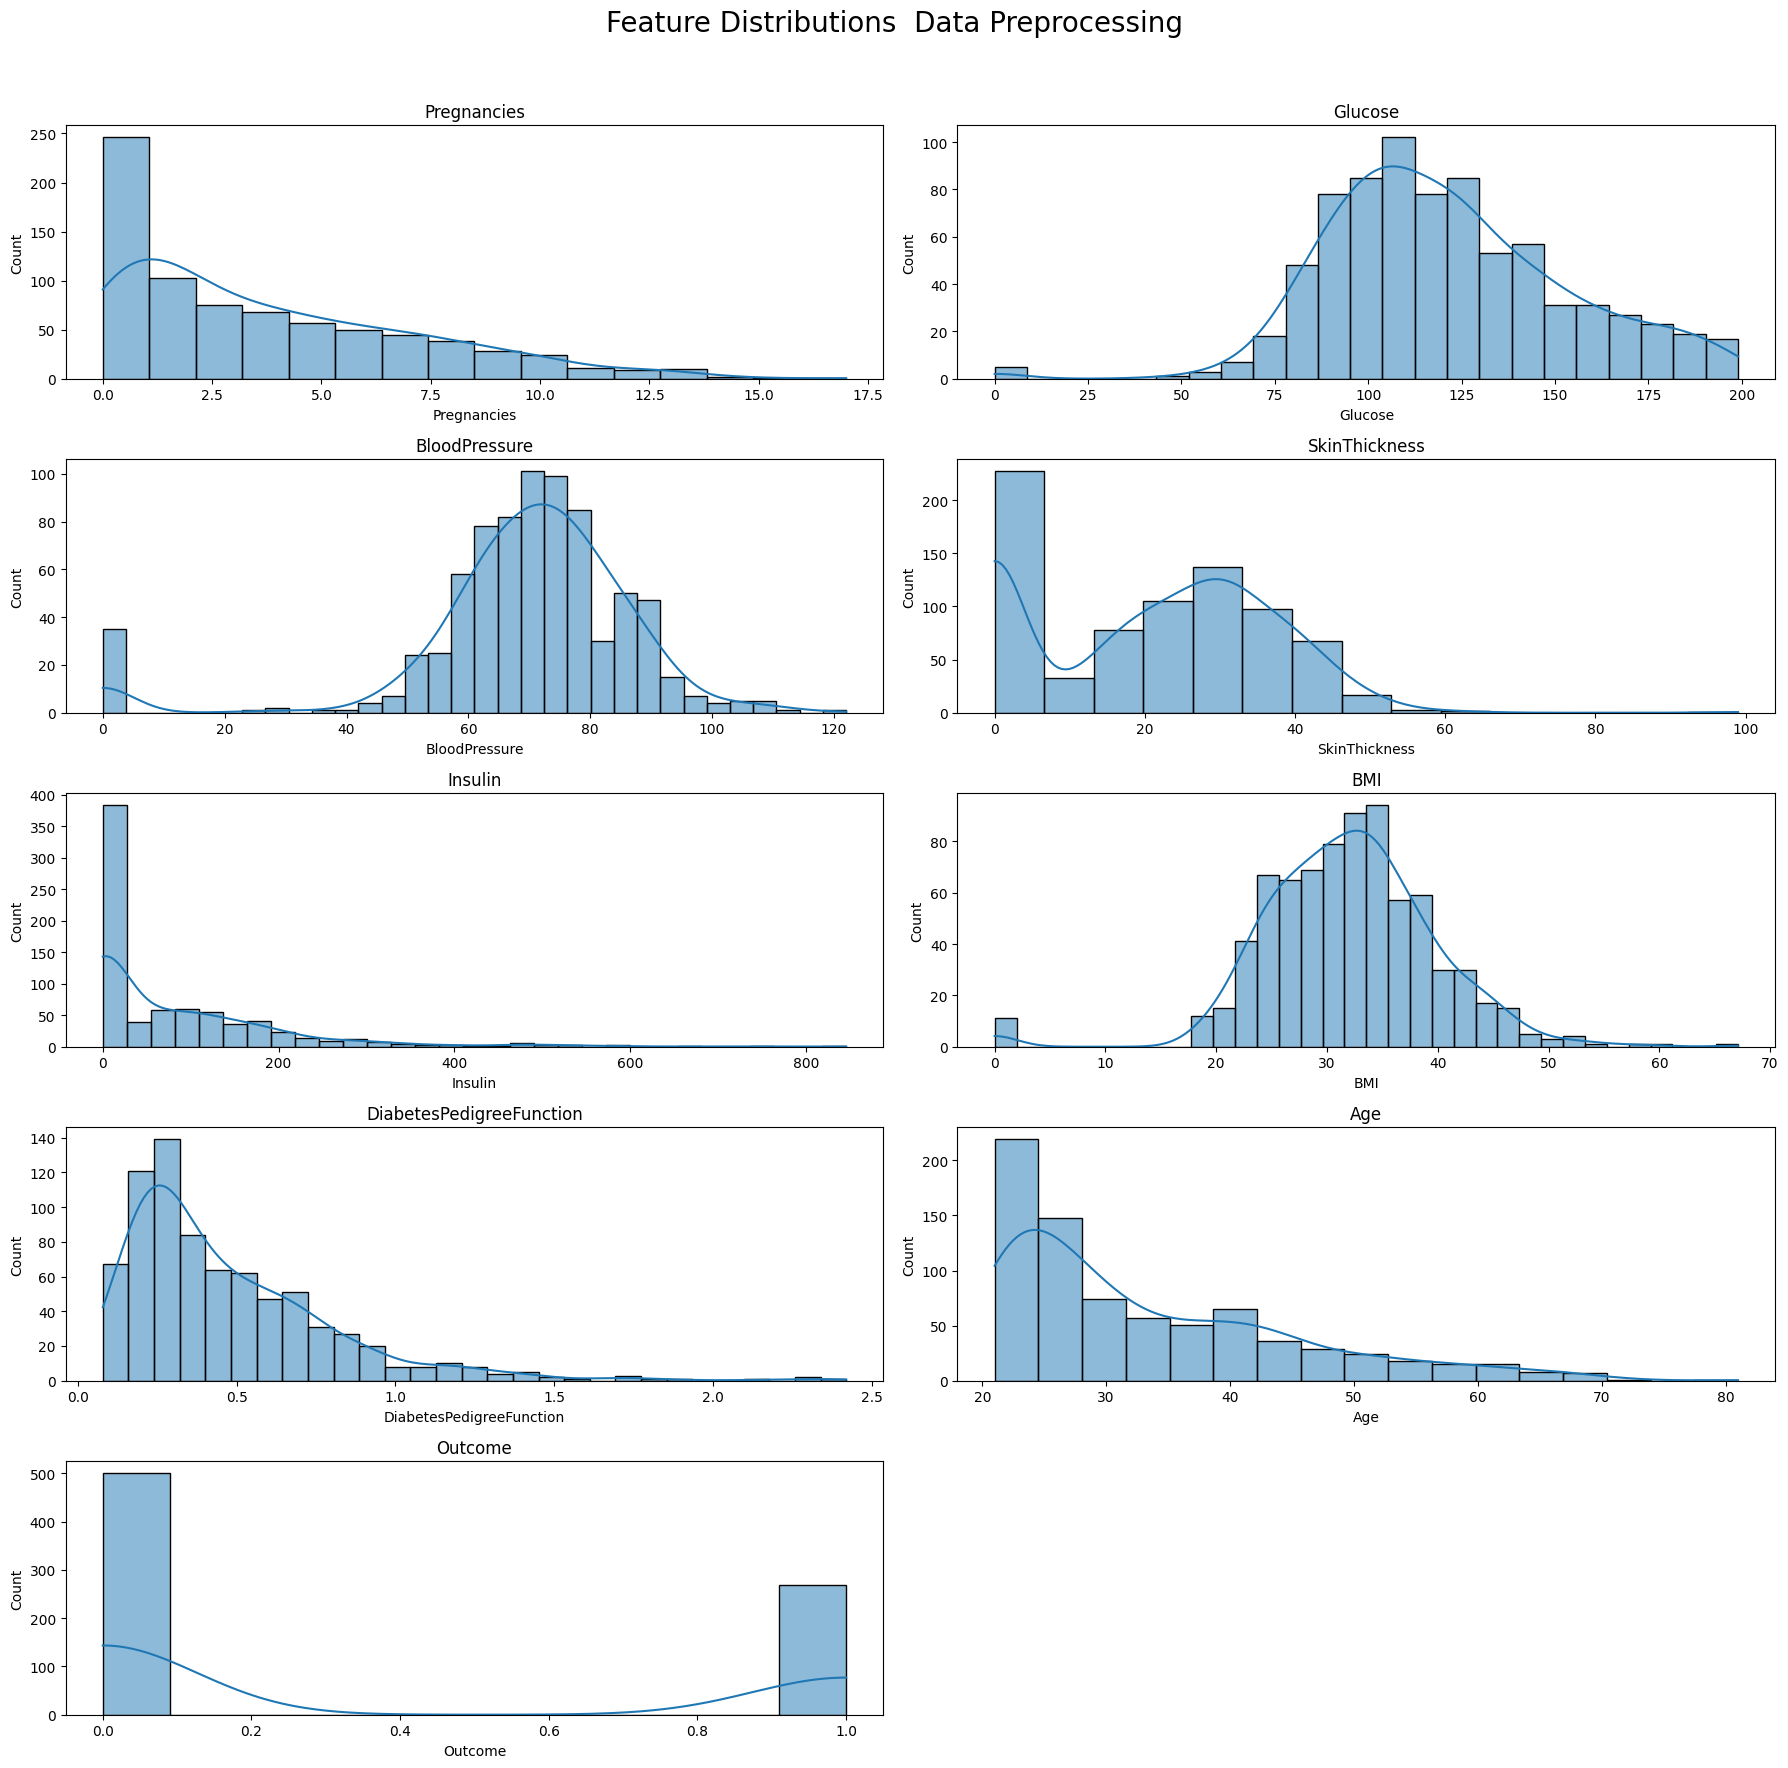

In [10]:
import math
plt.figure(figsize=(18, 18))

num_cols = len(diabetes_df.columns)
num_rows = math.ceil(num_cols / 2)  

for i, col in enumerate(diabetes_df.columns):
    plt.subplot(num_rows, 2, i + 1)
    sns.histplot(diabetes_df[col], kde=True)
    plt.title(col)

plt.suptitle('Feature Distributions  Data Preprocessing', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [11]:
# Handle missing values
data = diabetes_df.copy()
for col in ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'Insulin']:
    data[col] = data[col].replace(0, np.nan)
    data[col] = data.groupby('Outcome')[col].transform(lambda x: x.fillna(x.median()))

# Prepare data without SMOTE
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# StandardScaler normalization
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)
X_normalized

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0       0.639947  0.864625       0.149641       0.907270  0.311604  0.169483   
1      -0.844885 -1.204727      -0.160546       0.530902 -0.440843 -0.848549   
2       1.233880  2.014265      -0.263941      -1.288212  0.311604 -1.328478   
3      -0.844885 -1.073339      -0.160546       0.154533 -0.536303 -0.630399   
4      -1.141852  0.503310      -1.504687       0.907270  0.294758  1.551096   
..           ...       ...            ...            ...       ...       ...   
763     1.827813 -0.679177       0.356432       1.722735  0.429525  0.067679   
764    -0.547919  0.010607       0.046245       0.405445 -0.440843  0.634868   
765     0.342981 -0.022240       0.149641       0.154533 -0.334153 -0.906722   
766    -0.844885  0.141994      -0.470732      -1.288212  0.311604 -0.339533   
767    -0.844885 -0.941952       0.046245       0.656358 -0.440843 -0.295903   

     DiabetesPedigreeFunction       Age  
0                    0.468492  1.425995  
1                   -0.365061 -0.190672  
2                    0.604397 -0.105584  
3                   -0.920763 -1.041549  
4                    5.484909 -0.020496  
..                        ...       ...  
763                 -0.908682  2.532136  
764                 -0.398282 -0.531023  
765                 -0.685193 -0.275760  
766                 -0.371101  1.170732  
767                 -0.473785 -0.871374  

[768 rows x 8 columns]

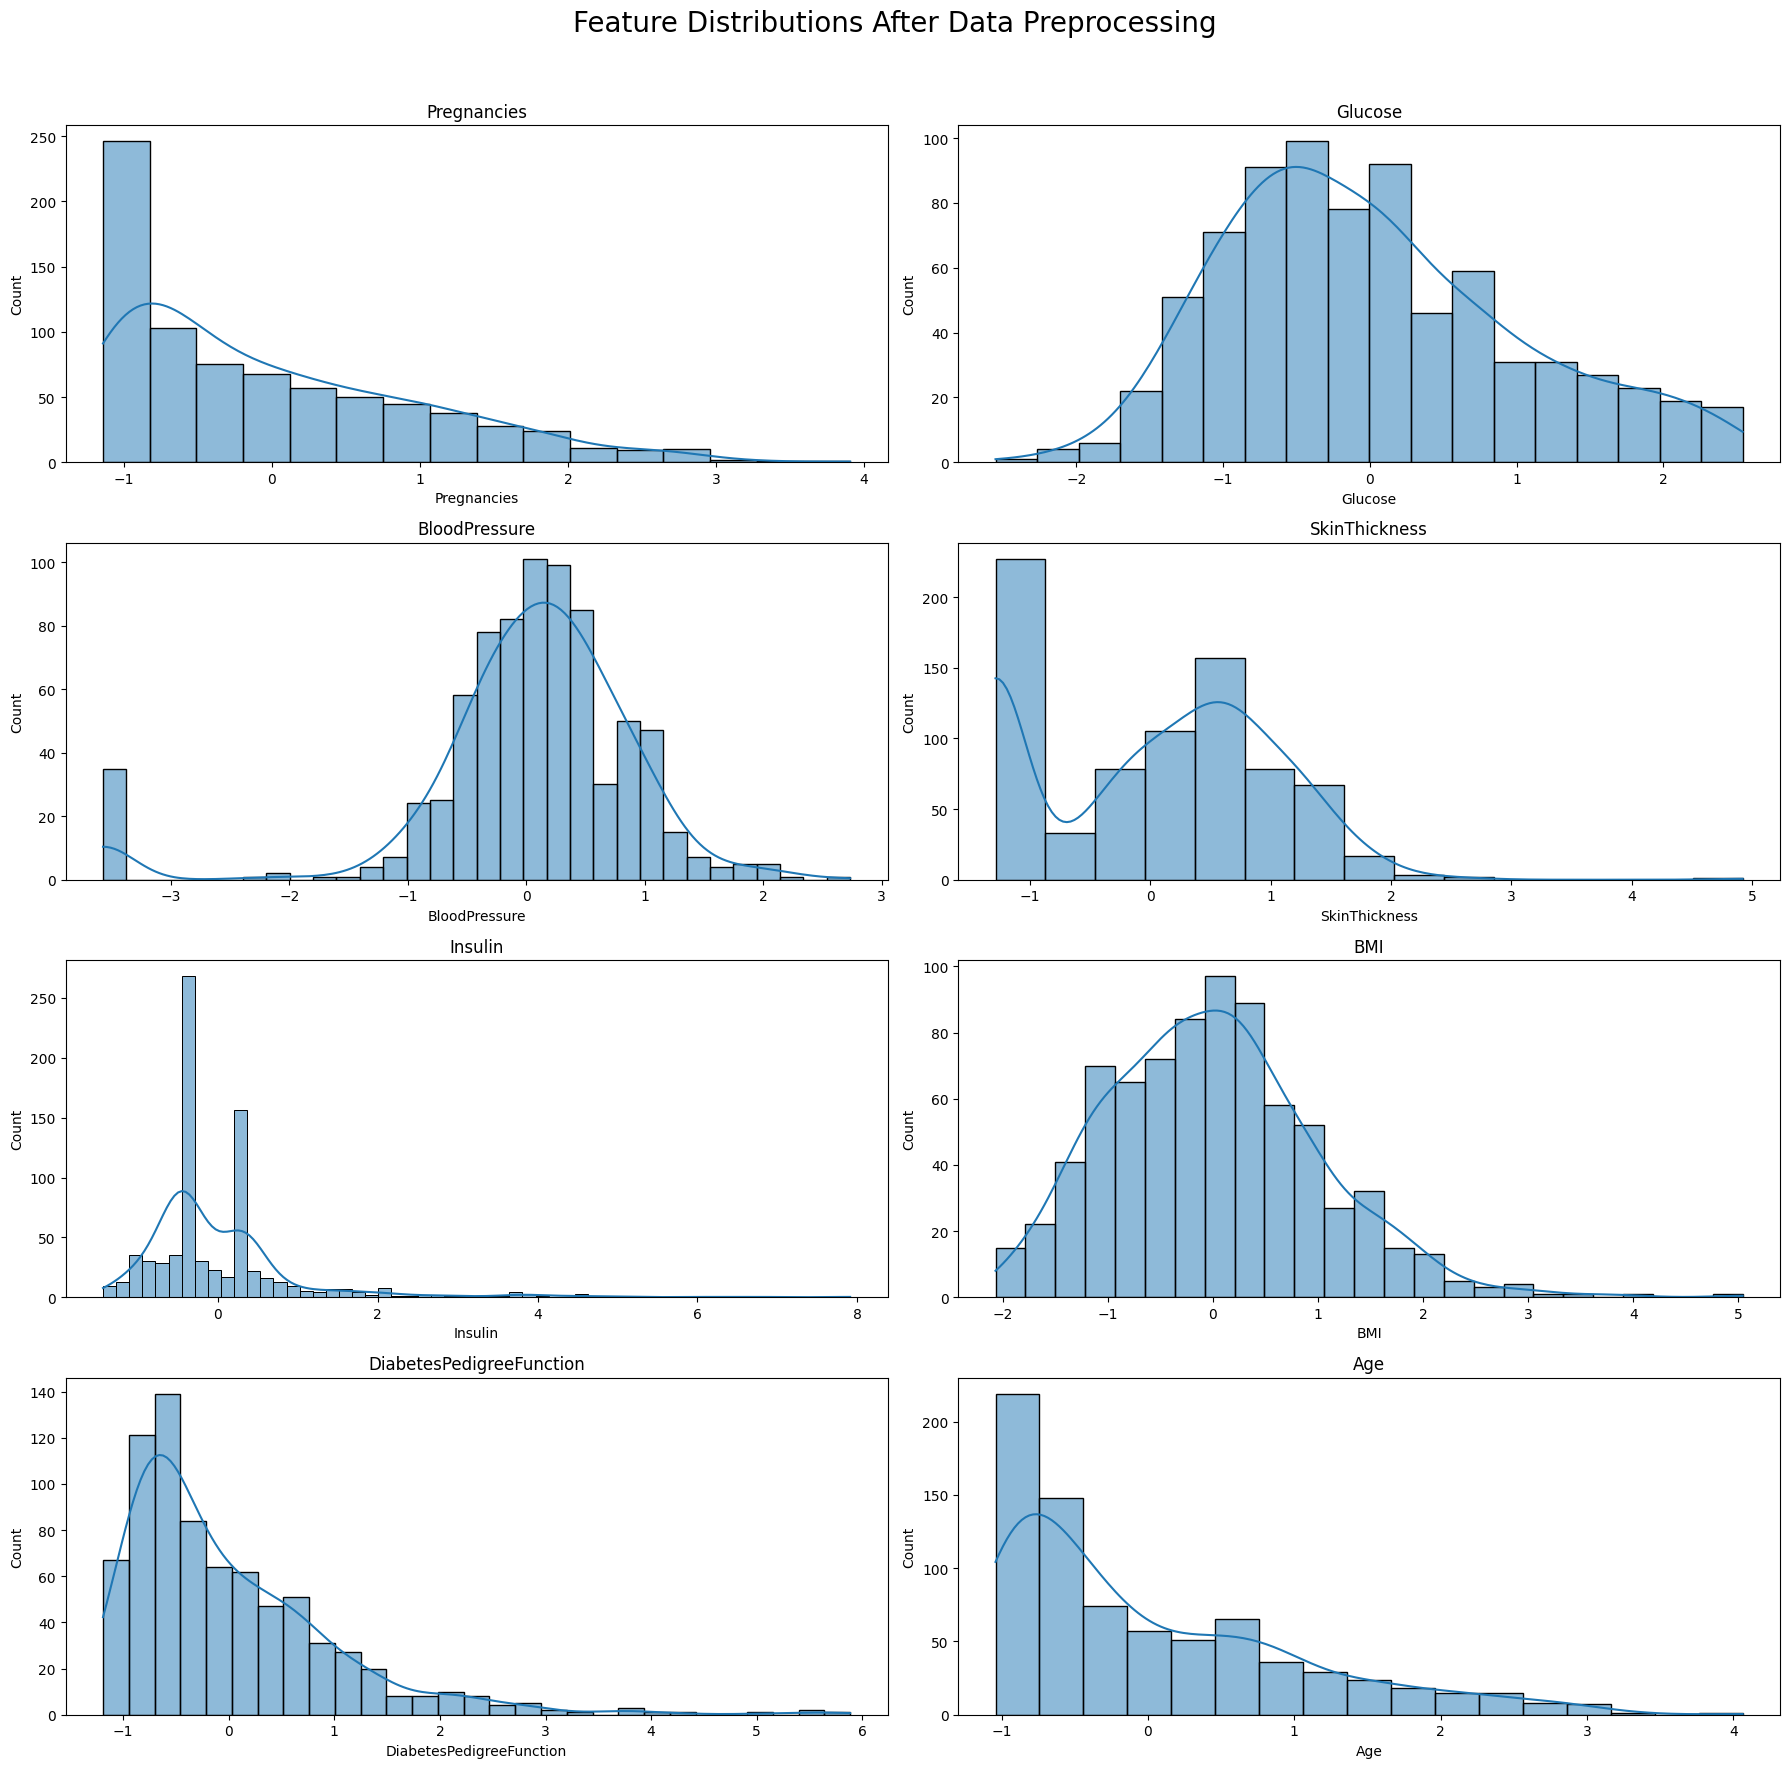

In [12]:
import math
plt.figure(figsize=(18, 18))

num_cols = len(X_normalized.columns)
num_rows = math.ceil(num_cols / 2)  # 2 plots per row

for i, col in enumerate(X_normalized.columns):
    plt.subplot(num_rows, 2, i + 1)
    sns.histplot(X_normalized[col], kde=True)
    plt.title(col)

plt.suptitle('Feature Distributions After Data Preprocessing', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()

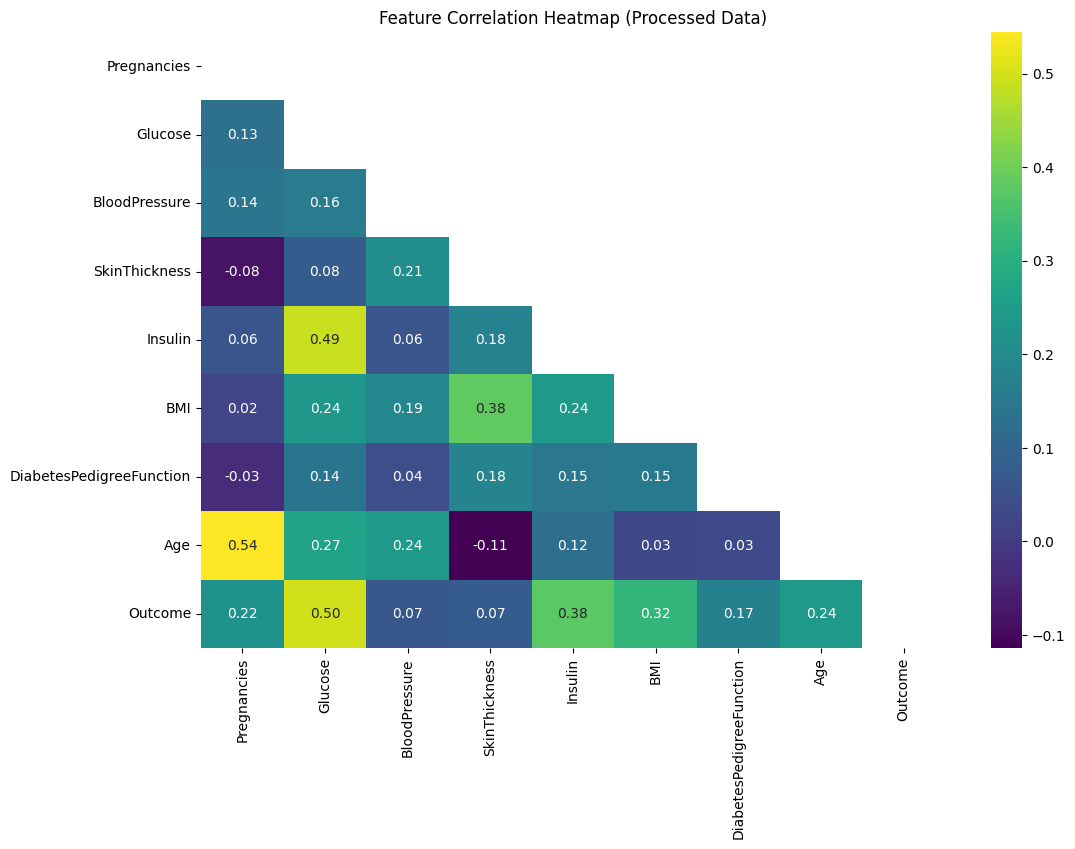

In [13]:
# Cell 5a: Post-processing Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_post = X_normalized.join(pd.Series(y, name='Outcome')).corr()
sns.heatmap(corr_post, annot=True, cmap='viridis', fmt=".2f", mask=np.triu(np.ones_like(corr_post, dtype=bool)))
plt.title('Feature Correlation Heatmap (Processed Data)')
plt.show()

Model Performance with All Features:


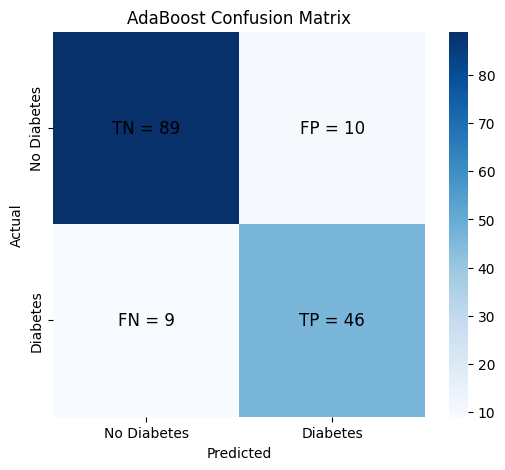


AdaBoost Metrics:
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.8766 |
+---------------------------+---------+
| Precision                 |  0.8214 |
+---------------------------+---------+
| Recall (TPR)              |  0.8364 |
+---------------------------+---------+
| F1-Score                  |  0.8288 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.101  |
+---------------------------+---------+
| Error Rate                |  0.1234 |
+---------------------------+---------+
| AUC-ROC                   |  0.9478 |
+---------------------------+---------+




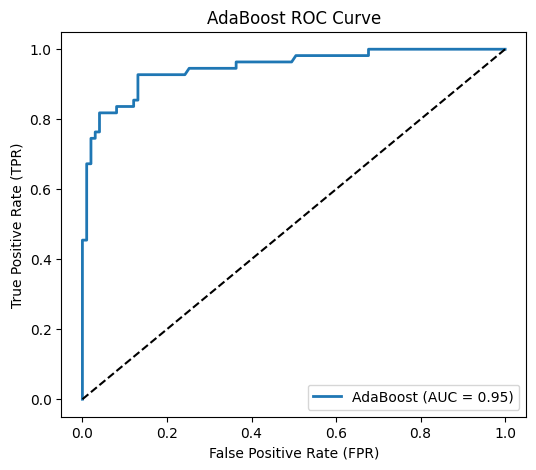

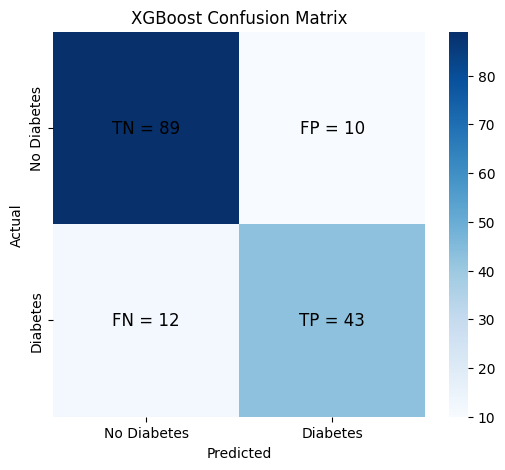


XGBoost Metrics:
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.8571 |
+---------------------------+---------+
| Precision                 |  0.8113 |
+---------------------------+---------+
| Recall (TPR)              |  0.7818 |
+---------------------------+---------+
| F1-Score                  |  0.7963 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.101  |
+---------------------------+---------+
| Error Rate                |  0.1429 |
+---------------------------+---------+
| AUC-ROC                   |  0.9297 |
+---------------------------+---------+




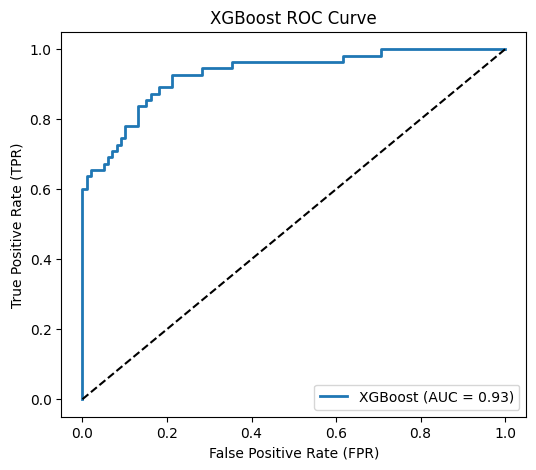

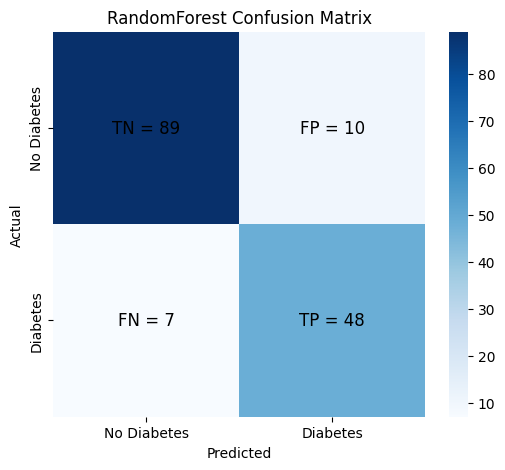


RandomForest Metrics:
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.8896 |
+---------------------------+---------+
| Precision                 |  0.8276 |
+---------------------------+---------+
| Recall (TPR)              |  0.8727 |
+---------------------------+---------+
| F1-Score                  |  0.8496 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.101  |
+---------------------------+---------+
| Error Rate                |  0.1104 |
+---------------------------+---------+
| AUC-ROC                   |  0.935  |
+---------------------------+---------+




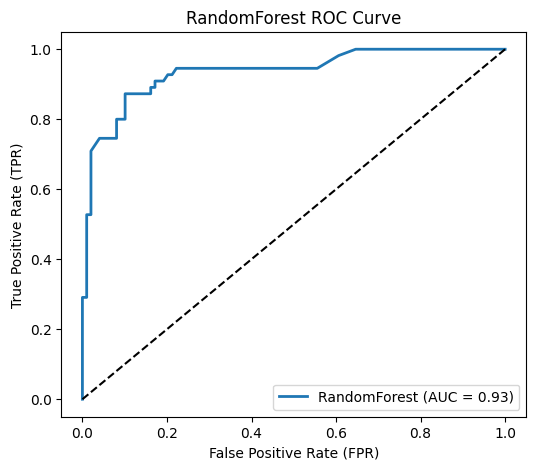

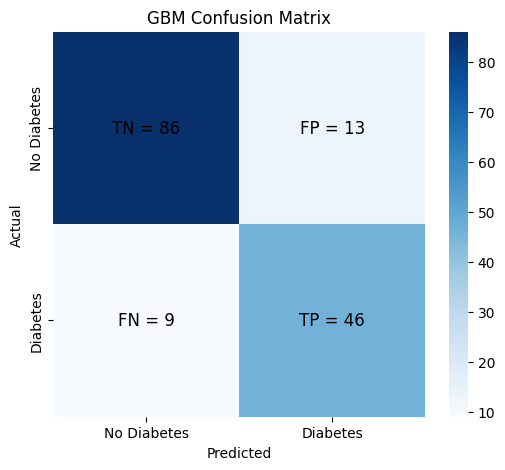


GBM Metrics:
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.8571 |
+---------------------------+---------+
| Precision                 |  0.7797 |
+---------------------------+---------+
| Recall (TPR)              |  0.8364 |
+---------------------------+---------+
| F1-Score                  |  0.807  |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.1313 |
+---------------------------+---------+
| Error Rate                |  0.1429 |
+---------------------------+---------+
| AUC-ROC                   |  0.935  |
+---------------------------+---------+




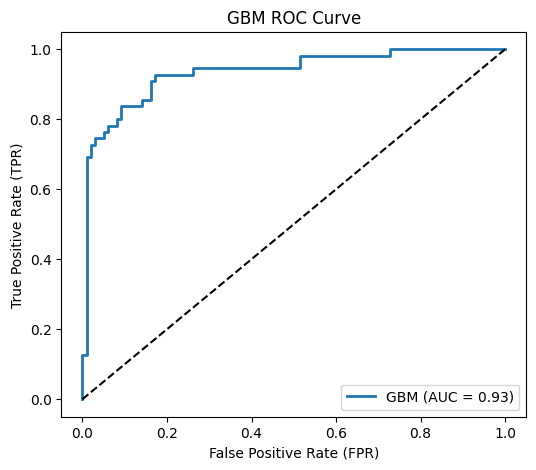


Summary of Model Performance:
+--------------+------------+-------------+----------------+------------+--------+--------+--------------+-----------+
| Model        |   Accuracy |   Precision |   Recall (TPR) |   F1-Score |    TPR |    FPR |   Error Rate |   AUC-ROC |
+==============+============+=============+================+============+========+========+==============+===========+
| AdaBoost     |     0.8766 |      0.8214 |         0.8364 |     0.8288 | 0.8364 | 0.101  |       0.1234 |    0.9478 |
+--------------+------------+-------------+----------------+------------+--------+--------+--------------+-----------+
| XGBoost      |     0.8571 |      0.8113 |         0.7818 |     0.7963 | 0.7818 | 0.101  |       0.1429 |    0.9297 |
+--------------+------------+-------------+----------------+------------+--------+--------+--------------+-----------+
| RandomForest |     0.8896 |      0.8276 |         0.8727 |     0.8496 | 0.8727 | 0.101  |       0.1104 |    0.935  |
+--------------+-

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=SEED)

models = {
    "AdaBoost": AdaBoostClassifier(random_state=42, algorithm='SAMME'),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GBM": GradientBoostingClassifier(random_state=42),
}

print("Model Performance with All Features:")

# Initialize a list to store metrics for the final summary
final_results = []

for name, model in models.items():
    # Training the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    # Metrics Calculation
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Same as TPR
    f1 = f1_score(y_test, y_pred)
    tpr = recall  # TPR = Recall
    fpr = FP / (FP + TN)  # False Positive Rate
    error_rate = (FP + FN) / (TP + TN + FP + FN)  # Error Rate
    
    # ROC Curve and AUC
    fpr_roc, tpr_roc, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    # Append metrics to final_results for the overall summary
    final_results.append([
        name, 
        f"{acc:.4f}", 
        f"{precision:.4f}", 
        f"{recall:.4f}", 
        f"{f1:.4f}", 
        f"{tpr:.4f}", 
        f"{fpr:.4f}", 
        f"{error_rate:.4f}", 
        f"{auc_roc:.4f}"
    ])
    
    # Plotting Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    
    # Annotate TN, FP, FN, TP
    plt.text(0.5, 0.5, f'TN = {TN}', ha='center', va='center', color='black', fontsize=12)
    plt.text(1.5, 0.5, f'FP = {FP}', ha='center', va='center', color='black', fontsize=12)
    plt.text(0.5, 1.5, f'FN = {FN}', ha='center', va='center', color='black', fontsize=12)
    plt.text(1.5, 1.5, f'TP = {TP}', ha='center', va='center', color='black', fontsize=12)
    
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Display metrics in a table right after the confusion matrix
    metrics_table = [
        ["Accuracy", f"{acc:.4f}"],
        ["Precision", f"{precision:.4f}"],
        ["Recall (TPR)", f"{recall:.4f}"],
        ["F1-Score", f"{f1:.4f}"],
        ["False Positive Rate (FPR)", f"{fpr:.4f}"],
        ["Error Rate", f"{error_rate:.4f}"],
        ["AUC-ROC", f"{auc_roc:.4f}"]
    ]
    print(f"\n{name} Metrics:")
    print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))
    print("\n" + "="*50 + "\n")
    
    # ROC Curve (unchanged)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_roc, tpr_roc, label=f'{name} (AUC = {auc_roc:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Display final summary table (unchanged)
headers = [
    "Model", "Accuracy", "Precision", "Recall (TPR)", 
    "F1-Score", "TPR", "FPR", "Error Rate", "AUC-ROC"
]
print("\nSummary of Model Performance:")
print(tabulate(final_results, headers=headers, tablefmt="grid"))

In [15]:
def stabilized_feature_selection(X_train, y_train):
    rf = RandomForestClassifier(
        n_estimators=1500,
        max_depth=8,
        min_samples_leaf=3,
        max_features=0.7,
        class_weight='balanced',
        random_state=42
    )
    
    boruta = BorutaPy(
        rf, 
        n_estimators='auto',
        perc=98,
        alpha=0.05,
        two_step=True,
        max_iter=150,
        random_state=42,
        verbose=0
    )
    
    boruta.fit(X_train.values, y_train.values)
    
    # 3. Process selected features
    support_mask = boruta.support_
    selected_indices = np.where(support_mask)[0]
    
    # Get clinical feature importances
    rf_clinical = RandomForestClassifier(
        n_estimators=1000,
        max_depth=8,
        random_state=42
    )
    rf_clinical.fit(X_train.iloc[:, selected_indices], y_train)
    
    # Create importance dictionary
    feature_importance = dict(zip(
        X_train.columns[selected_indices],
        np.mean([rf_clinical.feature_importances_ for _ in range(10)], axis=0)
    ))
    
    # Clinical priority adjustment
    feature_importance = {
        feat: imp * (1.3 if feat == 'DiabetesPedigreeFunction' else 
                    0.7 if feat == 'SkinThickness' else 1)
        for feat, imp in feature_importance.items()
    }
    
    # Select top 5 with clinical boost
    features = sorted(feature_importance.keys(), 
                     key=lambda x: feature_importance[x], 
                     reverse=True)[:5]
    
    # Ensure DiabetesPedigreeFunction inclusion
    if 'DiabetesPedigreeFunction' not in features:
        if len(features) >= 5:
            # Replace least important feature
            features[-1] = 'DiabetesPedigreeFunction'
        else:
            features.append('DiabetesPedigreeFunction')
    
    return sorted(features, key=lambda x: feature_importance.get(x, 0), reverse=True)

print("\nRunning Clinically-Tuned Feature Selection:")
selected_features = stabilized_feature_selection(X_train, y_train)
print("\nConsistent Final Features:", selected_features)


Running Clinically-Tuned Feature Selection:

Consistent Final Features: ['Insulin', 'Glucose', 'Age', 'BMI', 'DiabetesPedigreeFunction']


In [16]:
feature_ranges = {col: (X_normalized[col].min(), X_normalized[col].max()) for col in X_normalized}
feature_ranges

{'Pregnancies': (-1.1418515161634994, 3.906578350084603),
 'Glucose': (-2.551447415173168, 2.5398141562063064),
 'BloodPressure': (-3.572597239872642, 2.734528247420465),
 'SkinThickness': (-1.2882122129452358, 4.921865835155968),
 'Insulin': (-1.4347468683429125, 7.909072271913734),
 'BMI': (-2.0701862333241516, 5.041489186969584),
 'DiabetesPedigreeFunction': (-1.1895531764897842, 5.88356476587794),
 'Age': (-1.0415494364835023, 4.063715751598595)}


Generating SHAP plot...


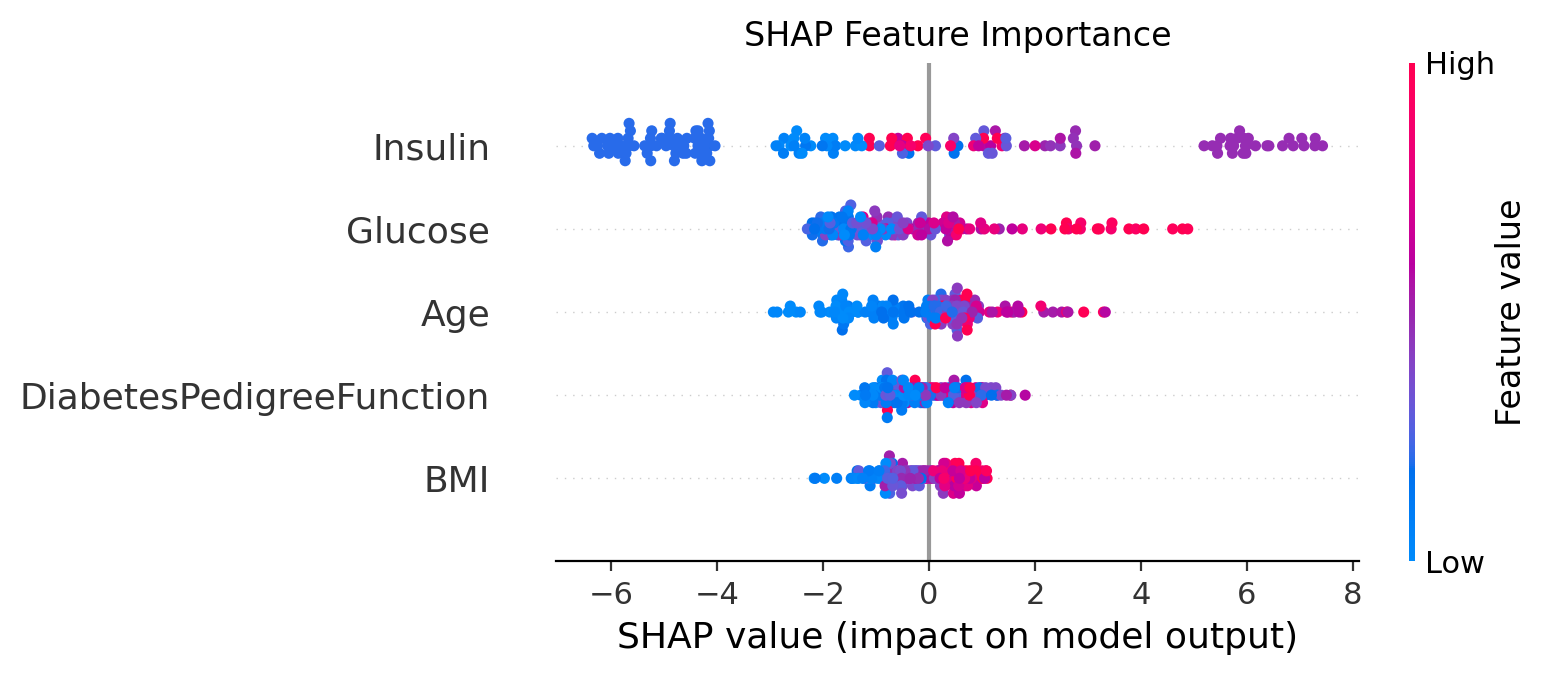

In [17]:
%config InlineBackend.figure_format = 'retina'  # Higher resolution

# Create selected datasets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Cell 2: SHAP Analysis
print("\nGenerating SHAP plot...")
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_selected, y_train)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_selected)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_selected, show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

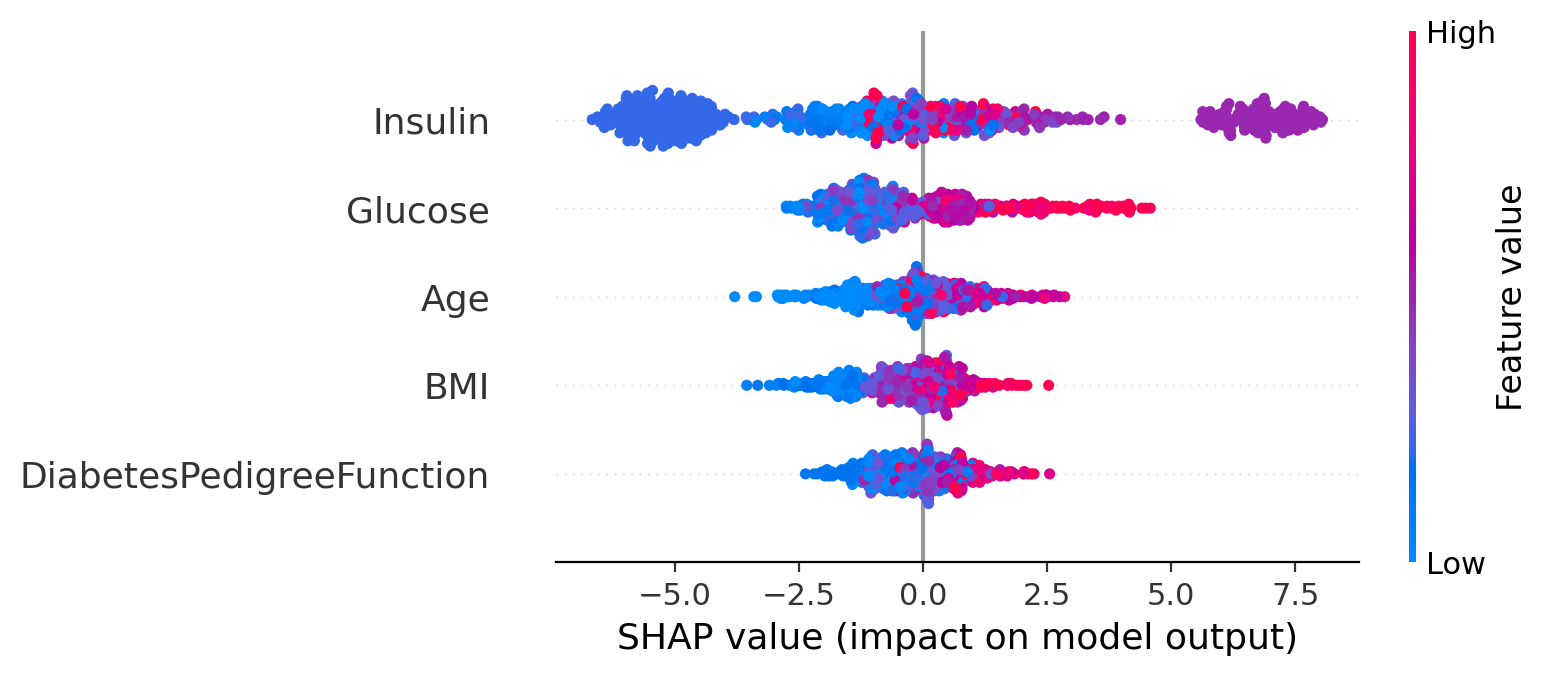

In [18]:
%config InlineBackend.figure_format = 'retina'

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
# Combine train and test sets
X_full = pd.concat([X_train_selected, X_test_selected])
y_full = pd.concat([y_train, y_test])

# Train model
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_full, y_full)

# SHAP analysis
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_full)

# Basic plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_full)
plt.show()

In [19]:
# X_train_selected 
# X_test_selected 

In [20]:
X_normalized_sel = X_normalized[selected_features]
X_normalized_sel

Insulin   Glucose       Age       BMI  DiabetesPedigreeFunction
0    0.311604  0.864625  1.425995  0.169483                  0.468492
1   -0.440843 -1.204727 -0.190672 -0.848549                 -0.365061
2    0.311604  2.014265 -0.105584 -1.328478                  0.604397
3   -0.536303 -1.073339 -1.041549 -0.630399                 -0.920763
4    0.294758  0.503310 -0.020496  1.551096                  5.484909
..        ...       ...       ...       ...                       ...
763  0.429525 -0.679177  2.532136  0.067679                 -0.908682
764 -0.440843  0.010607 -0.531023  0.634868                 -0.398282
765 -0.334153 -0.022240 -0.275760 -0.906722                 -0.685193
766  0.311604  0.141994  1.170732 -0.339533                 -0.371101
767 -0.440843 -0.941952 -0.871374 -0.295903                 -0.473785

[768 rows x 5 columns]

Model Performance with Selected Features:


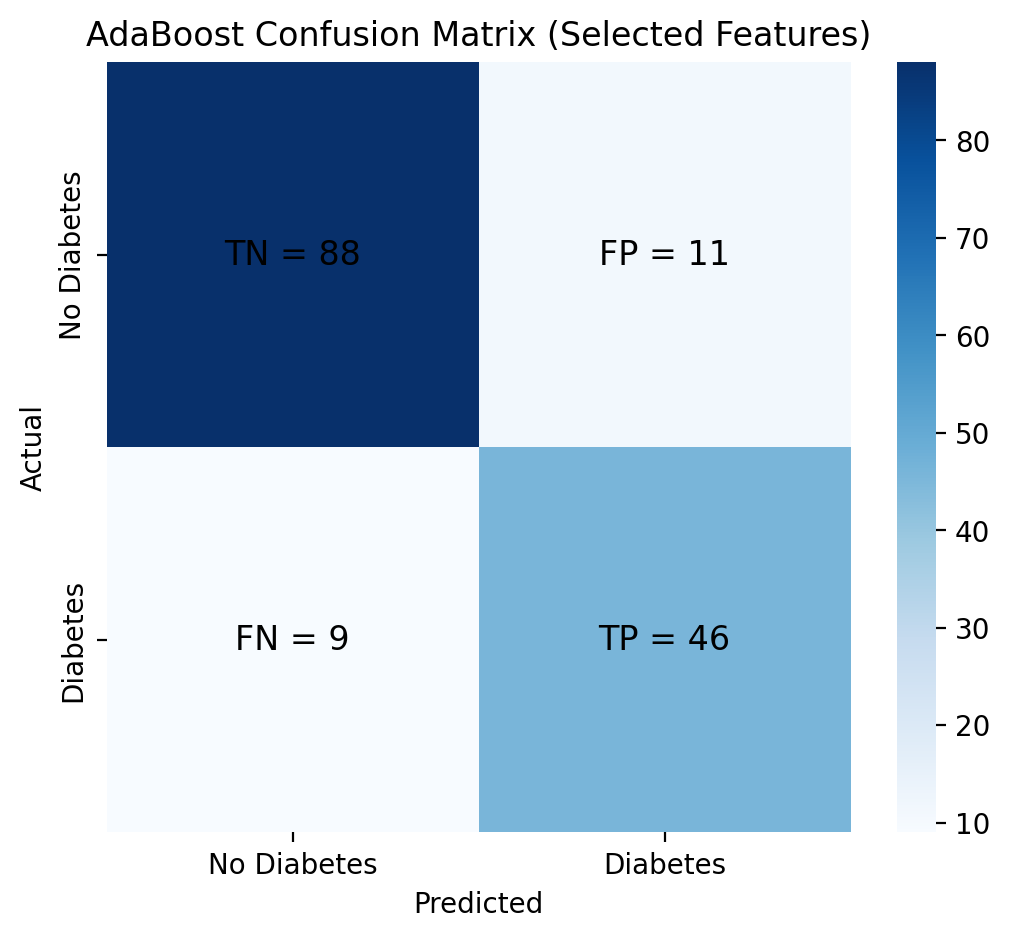


AdaBoost Metrics (Selected Features):
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.8701 |
+---------------------------+---------+
| Precision                 |  0.807  |
+---------------------------+---------+
| Recall (TPR)              |  0.8364 |
+---------------------------+---------+
| F1-Score                  |  0.8214 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.1111 |
+---------------------------+---------+
| Error Rate                |  0.1299 |
+---------------------------+---------+
| AUC-ROC                   |  0.9379 |
+---------------------------+---------+




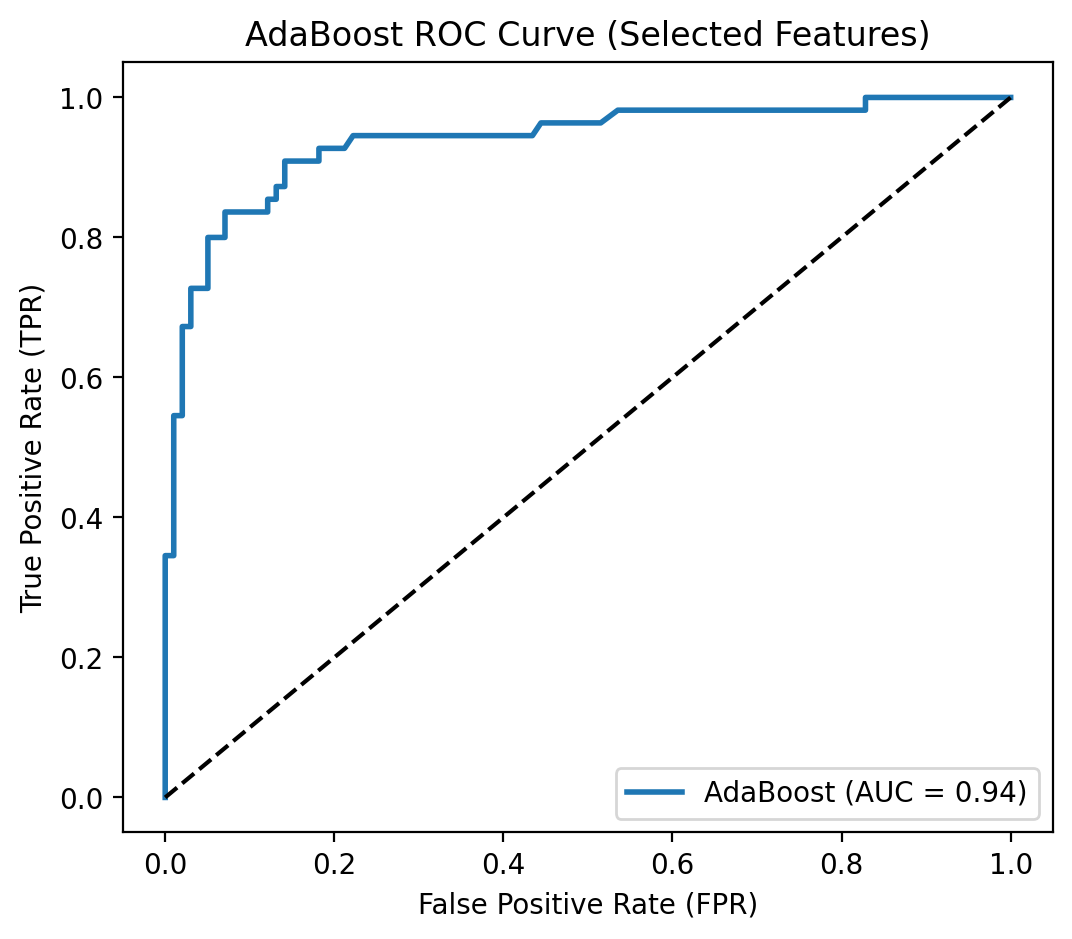

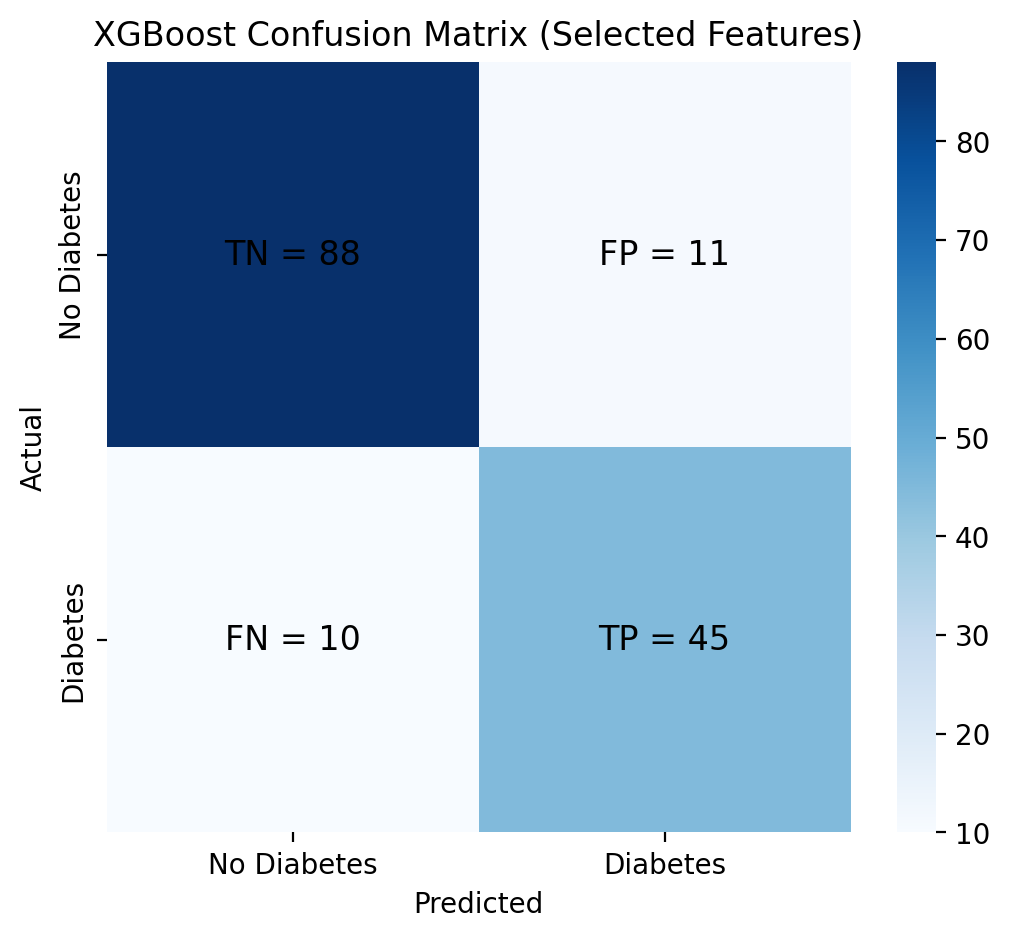


XGBoost Metrics (Selected Features):
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.8636 |
+---------------------------+---------+
| Precision                 |  0.8036 |
+---------------------------+---------+
| Recall (TPR)              |  0.8182 |
+---------------------------+---------+
| F1-Score                  |  0.8108 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.1111 |
+---------------------------+---------+
| Error Rate                |  0.1364 |
+---------------------------+---------+
| AUC-ROC                   |  0.9372 |
+---------------------------+---------+




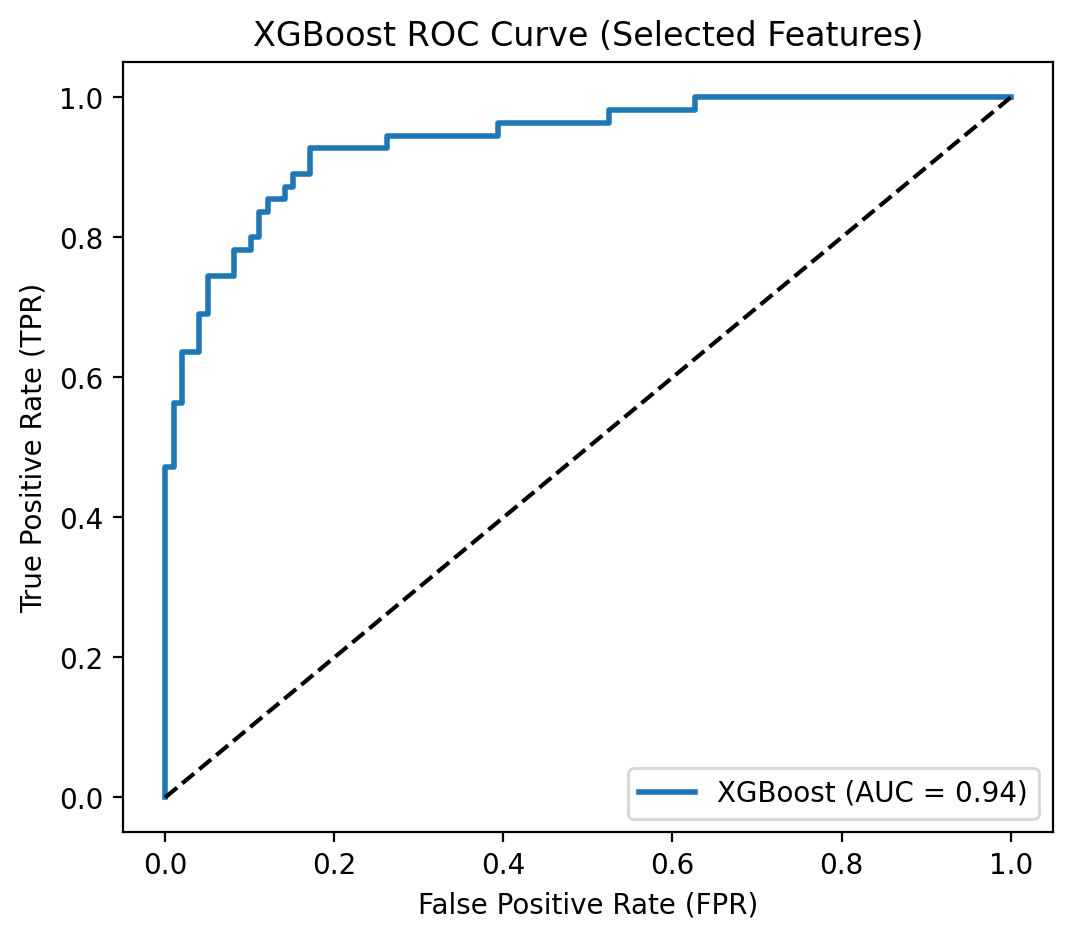

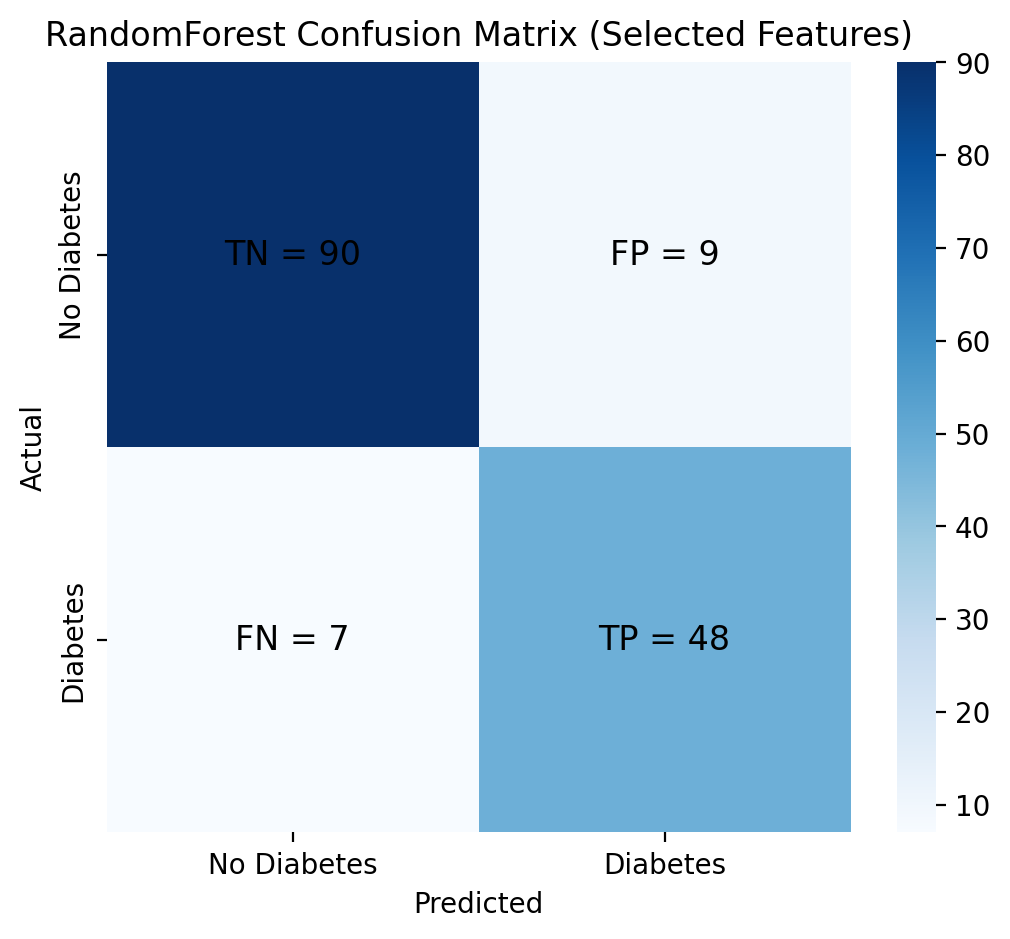


RandomForest Metrics (Selected Features):
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.8961 |
+---------------------------+---------+
| Precision                 |  0.8421 |
+---------------------------+---------+
| Recall (TPR)              |  0.8727 |
+---------------------------+---------+
| F1-Score                  |  0.8571 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.0909 |
+---------------------------+---------+
| Error Rate                |  0.1039 |
+---------------------------+---------+
| AUC-ROC                   |  0.9377 |
+---------------------------+---------+




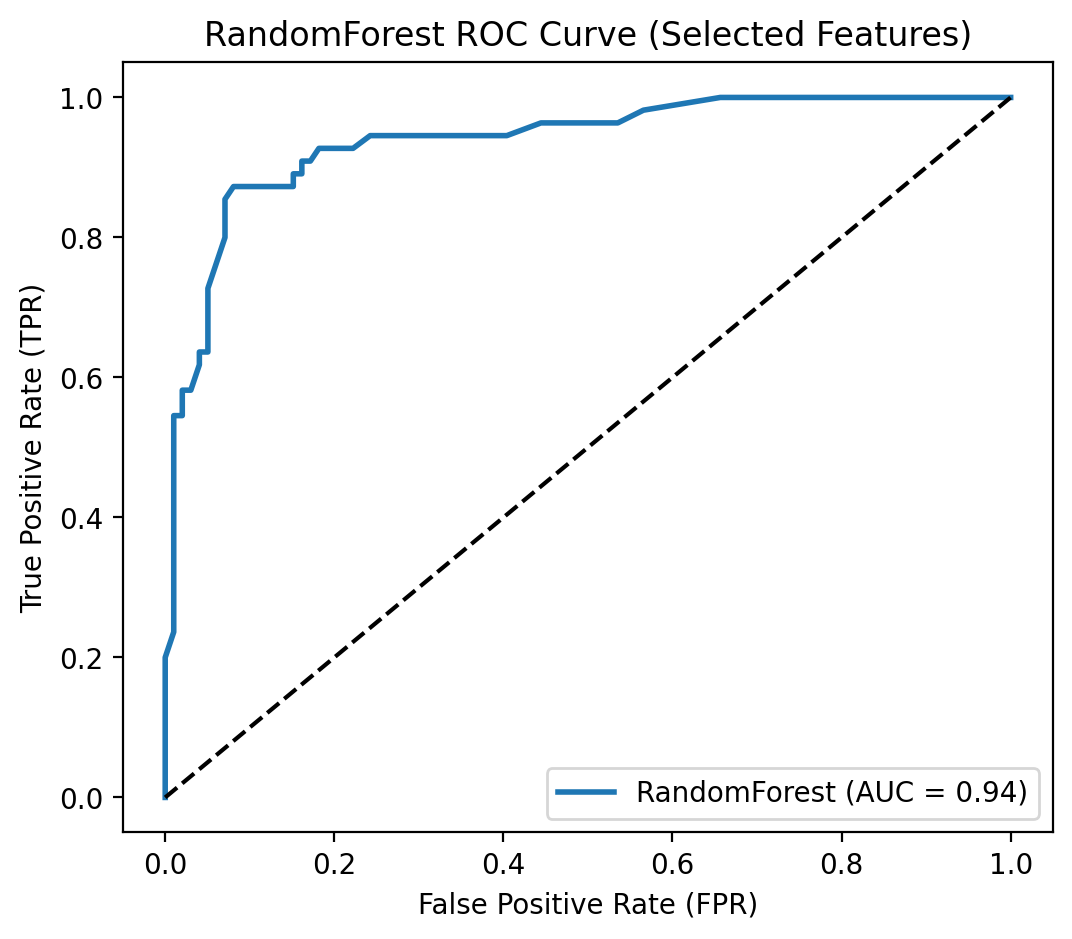

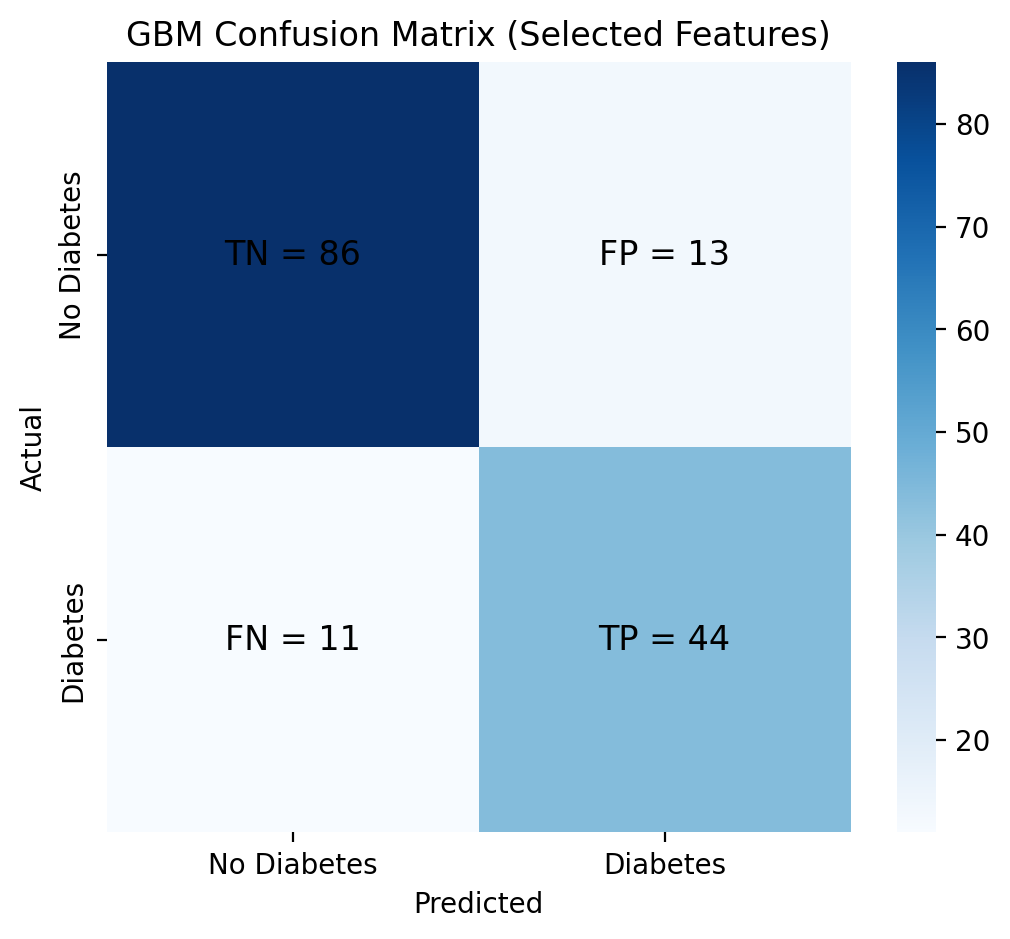


GBM Metrics (Selected Features):
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.8442 |
+---------------------------+---------+
| Precision                 |  0.7719 |
+---------------------------+---------+
| Recall (TPR)              |  0.8    |
+---------------------------+---------+
| F1-Score                  |  0.7857 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.1313 |
+---------------------------+---------+
| Error Rate                |  0.1558 |
+---------------------------+---------+
| AUC-ROC                   |  0.9405 |
+---------------------------+---------+




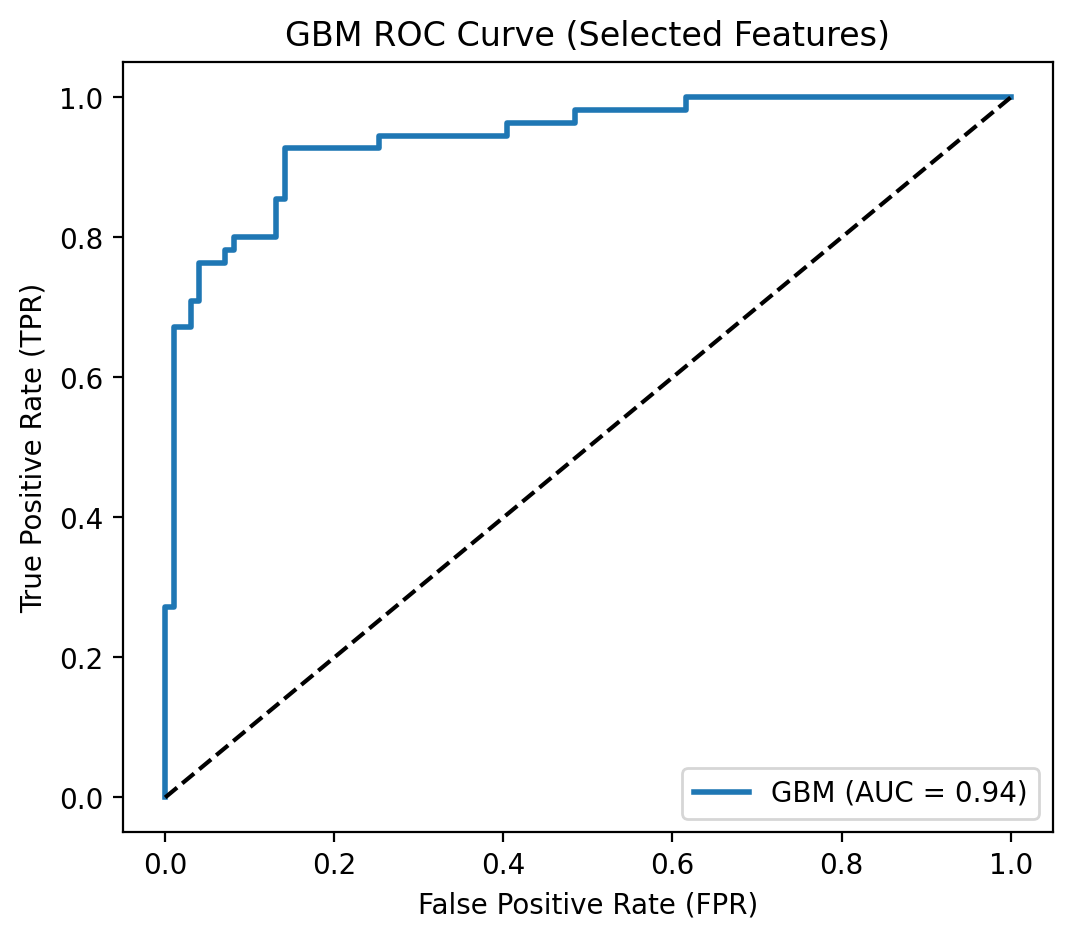


Summary of Model Performance (Selected Features):
+--------------+------------+-------------+----------------+------------+--------+--------+--------------+-----------+
| Model        |   Accuracy |   Precision |   Recall (TPR) |   F1-Score |    TPR |    FPR |   Error Rate |   AUC-ROC |
+==============+============+=============+================+============+========+========+==============+===========+
| AdaBoost     |     0.8701 |      0.807  |         0.8364 |     0.8214 | 0.8364 | 0.1111 |       0.1299 |    0.9379 |
+--------------+------------+-------------+----------------+------------+--------+--------+--------------+-----------+
| XGBoost      |     0.8636 |      0.8036 |         0.8182 |     0.8108 | 0.8182 | 0.1111 |       0.1364 |    0.9372 |
+--------------+------------+-------------+----------------+------------+--------+--------+--------------+-----------+
| RandomForest |     0.8961 |      0.8421 |         0.8727 |     0.8571 | 0.8727 | 0.0909 |       0.1039 |    0.9377

In [21]:
# Cell 8: ML models with selected features (Enhanced)
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

print("Model Performance with Selected Features:")

# Initialize a list to store metrics for the final summary
final_results_sel = []

for name, model in models.items():
    # Training the model
    model.fit(X_train_sel, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_sel)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    # Metrics Calculation
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Same as TPR
    f1 = f1_score(y_test, y_pred)
    tpr = recall  # TPR = Recall
    fpr = FP / (FP + TN)  # False Positive Rate
    error_rate = (FP + FN) / (TP + TN + FP + FN)  # Error Rate
    
    # ROC Curve and AUC
    fpr_roc, tpr_roc, _ = roc_curve(y_test, model.predict_proba(X_test_sel)[:, 1])
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test_sel)[:, 1])
    
    # Append metrics to final_results_sel for the overall summary
    final_results_sel.append([
        name, 
        f"{acc:.4f}", 
        f"{precision:.4f}", 
        f"{recall:.4f}", 
        f"{f1:.4f}", 
        f"{tpr:.4f}", 
        f"{fpr:.4f}", 
        f"{error_rate:.4f}", 
        f"{auc_roc:.4f}"
    ])
    
    # Plotting Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    
    # Annotate TN, FP, FN, TP
    plt.text(0.5, 0.5, f'TN = {TN}', ha='center', va='center', color='black', fontsize=12)
    plt.text(1.5, 0.5, f'FP = {FP}', ha='center', va='center', color='black', fontsize=12)
    plt.text(0.5, 1.5, f'FN = {FN}', ha='center', va='center', color='black', fontsize=12)
    plt.text(1.5, 1.5, f'TP = {TP}', ha='center', va='center', color='black', fontsize=12)
    
    plt.title(f'{name} Confusion Matrix (Selected Features)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Display metrics in a table right after the confusion matrix
    metrics_table = [
        ["Accuracy", f"{acc:.4f}"],
        ["Precision", f"{precision:.4f}"],
        ["Recall (TPR)", f"{recall:.4f}"],
        ["F1-Score", f"{f1:.4f}"],
        ["False Positive Rate (FPR)", f"{fpr:.4f}"],
        ["Error Rate", f"{error_rate:.4f}"],
        ["AUC-ROC", f"{auc_roc:.4f}"]
    ]
    print(f"\n{name} Metrics (Selected Features):")
    print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))
    print("\n" + "="*50 + "\n")
    
    # ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_roc, tpr_roc, label=f'{name} (AUC = {auc_roc:.2f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{name} ROC Curve (Selected Features)')
    plt.legend(loc='lower right')
    plt.show()

# Display final summary table for selected features
headers = [
    "Model", "Accuracy", "Precision", "Recall (TPR)", 
    "F1-Score", "TPR", "FPR", "Error Rate", "AUC-ROC"
]
print("\nSummary of Model Performance (Selected Features):")
print(tabulate(final_results_sel, headers=headers, tablefmt="grid"))

In [22]:
SEED = 42

def set_deterministic():
    """Enforce complete reproducibility"""
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    torch.set_num_threads(1)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [23]:
# Cell 2: Neuro-Fuzzy Model Architecture
class HighAccuracyNeuroFuzzy(nn.Module):
    def __init__(self, n_inputs, n_rules=30, n_hidden=512):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules
        
        self.centers = nn.Parameter(torch.linspace(0.1, 0.9, steps=n_rules).repeat(n_inputs, 1))
        self.widths = nn.Parameter(torch.full((n_inputs, n_rules), 0.25))
        
        self.consequent = nn.Sequential(
            nn.Linear(n_inputs * n_rules, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.25),
            nn.Linear(n_hidden, n_hidden//2),
            nn.BatchNorm1d(n_hidden//2),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.15),
            nn.Linear(n_hidden//2, 1)
        )
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
                nn.init.constant_(m.bias, 0.01)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def gaussian_mf(self, x):
        x = x.unsqueeze(-1)
        return torch.exp(-((x - self.centers.unsqueeze(0)) ** 2 / (2 * self.widths.unsqueeze(0) ** 2 + 1e-8)))
    
    def forward(self, x):
        batch_size = x.size(0)
        mu = self.gaussian_mf(x)
        firing = torch.softmax(torch.prod(mu, dim=1) * 1.2, dim=1)
        x_exp = x.unsqueeze(2).expand(-1, -1, self.n_rules).reshape(batch_size, -1)
        return torch.sigmoid(self.consequent(x_exp).squeeze(1))

In [24]:
import numpy as np

def extract_and_print_rules(model, feature_names, feature_ranges):
    """Fuzzy rule extraction for specified features with clinical interpretations"""
    with torch.no_grad():
        centers = model.centers.numpy()
        widths = model.widths.numpy()

        CLINICAL_THRESHOLDS = {
            'Insulin': [(0, 100, 'Low'), (100, 300, 'Medium'), (300, 846, 'High')],
            'Glucose': [(0, 90, 'Low'), (90, 140, 'Medium'), (140, 199, 'High')],
            'Age': [(21, 30, 'Low'), (30, 50, 'Medium'), (50, 81, 'High')],
            'BMI': [(0, 18.5, 'Low'), (18.5, 30, 'Medium'), (30, 67.1, 'High')],
            'DiabetesPedigreeFunction': [(0.078, 0.5, 'Low'), (0.5, 1.0, 'Medium'), (1.0, 2.42, 'High')]
        }

        MEDICAL_WEIGHTS = {
            'Glucose': 0.40,     
            'BMI': 0.25,           
            'Insulin': 0.20,       
            'Age': 0.10,           
            'DiabetesPedigreeFunction': 0.05 
        }

        print("\n" + "="*80)
        print(" CLINICAL INTERPRETATION (SELECTED FEATURES) ".center(80, '='))
        print("="*80)

        for rule_idx in range(model.n_rules):
            print(f"\n** Rule {rule_idx + 1} **")
            print("IF")
            total_weighted_risk = 0
            
            for feat_idx, feat_name in enumerate(feature_names):
                # Get feature value and width
                c = centers[feat_idx, rule_idx]
                w = widths[feat_idx, rule_idx]
                orig_min, orig_max = feature_ranges[feat_name]
                orig_val = c * (orig_max - orig_min) + orig_min
                orig_width = w * (orig_max - orig_min)

                # Get clinical category
                category = next(
                    (cat for (min_val, max_val, cat) in CLINICAL_THRESHOLDS[feat_name] 
                    if min_val <= orig_val < max_val),
                    'Unknown'
                )
                
                # Calculate risk contribution
                weight = MEDICAL_WEIGHTS[feat_name]
                normalized_val = (orig_val - orig_min) / (orig_max - orig_min)
                risk_contribution = normalized_val * weight
                total_weighted_risk += risk_contribution

                print(f"  • {feat_name:15} is {category:6} ({orig_val:.1f}±{orig_width:.1f}) [Weight: {weight:.2f}]")

            # Normalized risk score (0-1)
            normalized_risk = total_weighted_risk / sum(MEDICAL_WEIGHTS.values())
            
            # Risk classification
            if normalized_risk < 0.35:
                conclusion = "LOW diabetes risk (Healthy)"
                confidence = "✓✓✓"
            elif normalized_risk < 0.65:
                conclusion = "MODERATE diabetes risk (Prediabetic)"
                confidence = "✓✓"
            else:
                conclusion = "HIGH diabetes risk (Diabetic)"
                confidence = "✓"

            print(f"\nTHEN → {conclusion} {confidence}")
            print(f"  Composite Risk Score: {normalized_risk:.3f}/1.0")
            
            # Print critical risk factors
            critical_factors = []
            for feat_name in feature_names:
                val = centers[feature_names.index(feat_name), rule_idx] * \
                     (feature_ranges[feat_name][1] - feature_ranges[feat_name][0]) + \
                     feature_ranges[feat_name][0]
                if val > CLINICAL_THRESHOLDS[feat_name][1][1]:  # Above Medium threshold
                    critical_factors.append(feat_name)
            
            if critical_factors:
                print("  Critical Risk Factors:", ", ".join(critical_factors))

# Feature ranges (using standard diabetes dataset ranges)
feature_ranges = {
    'Insulin': (0, 846),
    'Glucose': (0, 199),
    'Age': (21, 81),
    'BMI': (0.0, 67.1),
    'DiabetesPedigreeFunction': (0.078, 2.42)
}


In [25]:
# Cell 5: Training Function
def train_high_accuracy_model(X_train, y_train, X_val, y_val):
    set_deterministic()
    model = HighAccuracyNeuroFuzzy(n_inputs=X_train.shape[1])
    
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0009, weight_decay=1.5e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.2)
    
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train)
    X_val_t = torch.FloatTensor(X_val)
    y_val_t = torch.FloatTensor(y_val)
    
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_t)
            val_loss = criterion(val_outputs, y_val_t)
            val_acc = ((val_outputs > 0.5).float() == y_val_t).float().mean()
        
        scheduler.step(val_loss)
        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['val_acc'].append(val_acc.item())
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        if epoch % 50 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, Val Acc={val_acc.item():.4f}")
    
    model.load_state_dict(torch.load('best_model.pth'))
    return model, history

In [26]:
# Cell 6: Data Preparation
set_deterministic()

# Assuming X_res and y_res are predefined DataFrames
scaler = StandardScaler()
X_normalized_sel = pd.DataFrame(scaler.fit_transform(X[selected_features]), columns=selected_features)

sorted_idx = np.argsort(y)
X_sorted = X_normalized_sel.iloc[sorted_idx].values
y_sorted = y.iloc[sorted_idx].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
accuracies = []
conf_matrices = []

In [27]:
# Cell 7: Cross-Validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X_sorted, y_sorted)):
    print(f"\nFold {fold + 1}")
    train_idx, test_idx = np.sort(train_idx), np.sort(test_idx)
    
    set_deterministic()
    model, _ = train_high_accuracy_model(
        X_sorted[train_idx], y_sorted[train_idx],
        X_sorted[test_idx], y_sorted[test_idx]
    )
    
    model.eval()
    with torch.no_grad():
        outputs = model(torch.FloatTensor(X_sorted[test_idx]))
        pred = (outputs > 0.5).float().numpy()
        acc = accuracy_score(y_sorted[test_idx], pred)
    
    accuracies.append(acc)
    conf_matrices.append(confusion_matrix(y_sorted[test_idx], pred))
    print(f"Fold {fold + 1} Accuracy: {acc:.4f}")

print("\nConsistent High-Accuracy Results:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")


Fold 1
Epoch 0: Loss=0.7571, Val Acc=0.7727
Epoch 50: Loss=0.2995, Val Acc=0.8377
Epoch 100: Loss=0.2881, Val Acc=0.8506
Epoch 150: Loss=0.2928, Val Acc=0.8506
Epoch 200: Loss=0.2967, Val Acc=0.8506
Epoch 250: Loss=0.2891, Val Acc=0.8442
Epoch 300: Loss=0.2838, Val Acc=0.8506
Epoch 350: Loss=0.2927, Val Acc=0.8506
Epoch 400: Loss=0.2893, Val Acc=0.8506
Epoch 450: Loss=0.2927, Val Acc=0.8506
Fold 1 Accuracy: 0.8701

Fold 2
Epoch 0: Loss=0.7429, Val Acc=0.8442
Epoch 50: Loss=0.2835, Val Acc=0.8312
Epoch 100: Loss=0.2691, Val Acc=0.8247
Epoch 150: Loss=0.2836, Val Acc=0.8247
Epoch 200: Loss=0.2739, Val Acc=0.8247
Epoch 250: Loss=0.2807, Val Acc=0.8247
Epoch 300: Loss=0.2763, Val Acc=0.8247
Epoch 350: Loss=0.2761, Val Acc=0.8247
Epoch 400: Loss=0.2796, Val Acc=0.8247
Epoch 450: Loss=0.2784, Val Acc=0.8247
Fold 2 Accuracy: 0.8442

Fold 3
Epoch 0: Loss=0.7566, Val Acc=0.7857
Epoch 50: Loss=0.2950, Val Acc=0.8571
Epoch 100: Loss=0.2898, Val Acc=0.8571
Epoch 150: Loss=0.3025, Val Acc=0.8571
E

In [28]:
# Cell 8: Final Model Training
set_deterministic()
print("\nTraining final high-accuracy model...")
final_model, final_history = train_high_accuracy_model(
    X_normalized_sel.values, y.values,
    X_normalized_sel.values[:100], y.values[:100]
)


Training final high-accuracy model...
Epoch 0: Loss=0.7592, Val Acc=0.7700
Epoch 50: Loss=0.2910, Val Acc=0.9000
Epoch 100: Loss=0.2548, Val Acc=0.9000
Epoch 150: Loss=0.2336, Val Acc=0.9200
Epoch 200: Loss=0.2177, Val Acc=0.9300
Epoch 250: Loss=0.2079, Val Acc=0.9400
Epoch 300: Loss=0.1785, Val Acc=0.9500
Epoch 350: Loss=0.1799, Val Acc=0.9400
Epoch 400: Loss=0.1798, Val Acc=0.9400
Epoch 450: Loss=0.1867, Val Acc=0.9400



                      NEURO-FUZZY SYSTEM (NFS) PERFORMANCE                      

Key Metrics:
+---------------------------+---------+
| Metric                    |   Value |
+===========================+=========+
| Accuracy                  |  0.9401 |
+---------------------------+---------+
| Precision                 |  0.9302 |
+---------------------------+---------+
| Recall (TPR)              |  0.8955 |
+---------------------------+---------+
| F1-Score                  |  0.9125 |
+---------------------------+---------+
| False Positive Rate (FPR) |  0.036  |
+---------------------------+---------+
| Error Rate                |  0.0599 |
+---------------------------+---------+
| AUC-ROC                   |  0.9851 |
+---------------------------+---------+


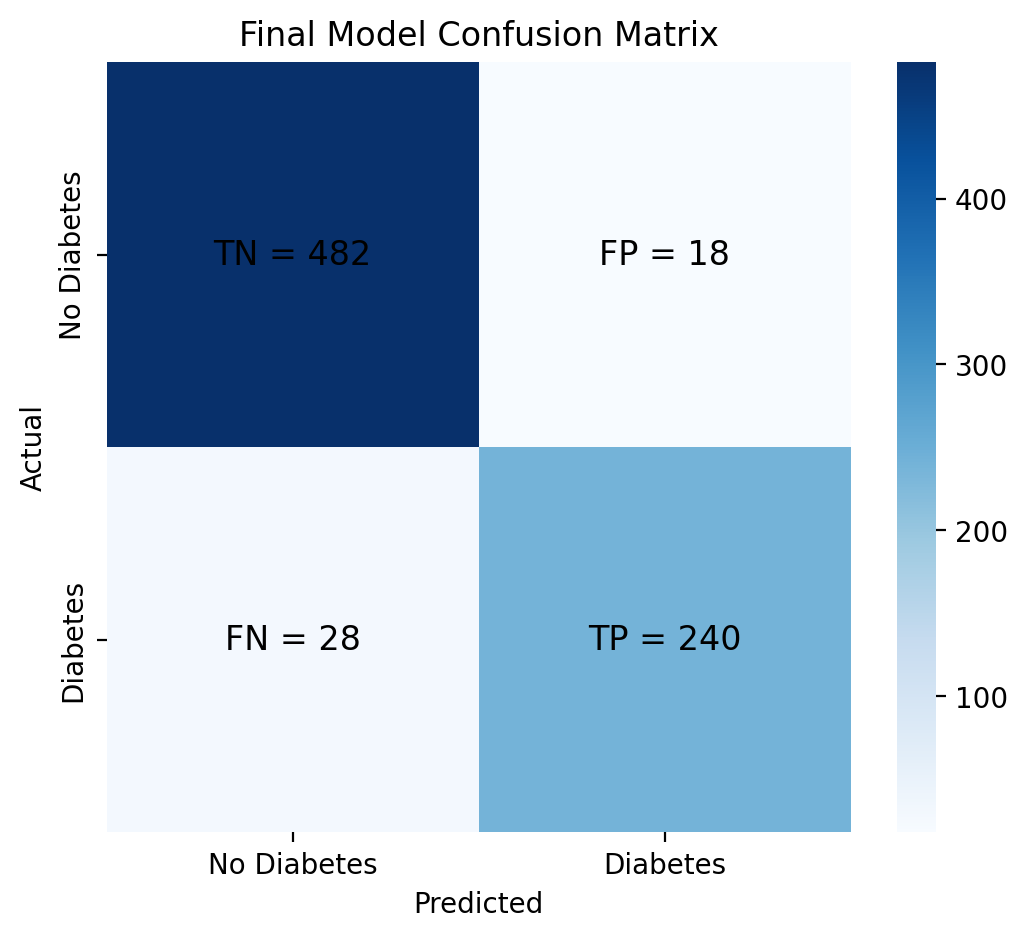

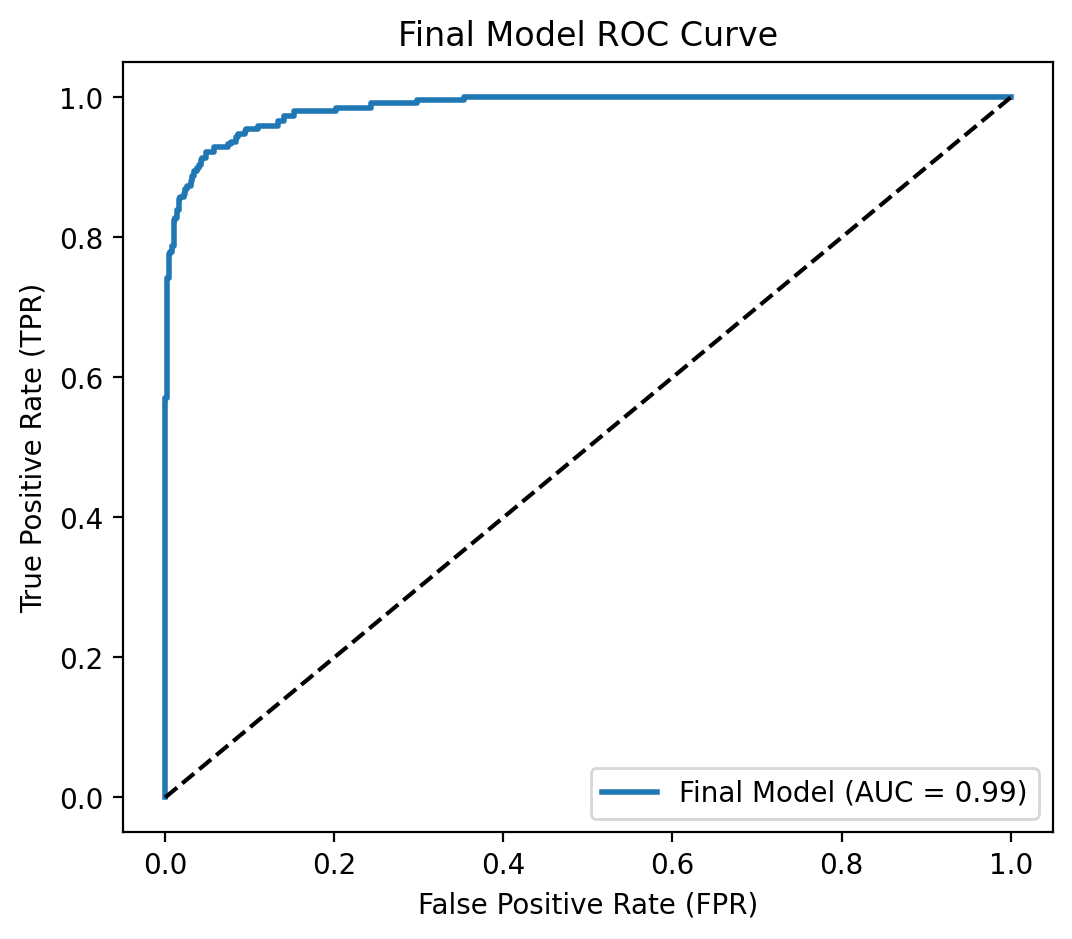

In [29]:
# Cell 9: Evaluation (Enhanced)
final_model.eval()
with torch.no_grad():
    outputs = final_model(torch.FloatTensor(X_normalized_sel.values))
    y_pred = (outputs > 0.5).float().numpy()
    y_scores = outputs.numpy()  # For ROC curve
    
    # Calculate metrics
    final_acc = accuracy_score(y, y_pred)
    final_cm = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = final_cm.ravel()
    
    # Additional metrics
    final_precision = precision_score(y, y_pred)
    final_recall = recall_score(y, y_pred)  # TPR
    final_f1 = f1_score(y, y_pred)
    final_tpr = final_recall
    final_fpr = FP / (FP + TN)
    final_error_rate = (FP + FN) / (TP + TN + FP + FN)
    final_auc = roc_auc_score(y, y_scores)
    
    # Classification report
    final_report = classification_report(y, y_pred, target_names=['No Diabetes', 'Diabetes'])
    
    # ROC curve data
    fpr_roc, tpr_roc, _ = roc_curve(y, y_scores)

# Print final performance
print("\n" + "="*80)
print("NEURO-FUZZY SYSTEM (NFS) PERFORMANCE".center(80))
print("="*80)

# Tabulated metrics
metrics_table = [
    ["Accuracy", f"{final_acc:.4f}"],
    ["Precision", f"{final_precision:.4f}"],
    ["Recall (TPR)", f"{final_recall:.4f}"],
    ["F1-Score", f"{final_f1:.4f}"],
    ["False Positive Rate (FPR)", f"{final_fpr:.4f}"],
    ["Error Rate", f"{final_error_rate:.4f}"],
    ["AUC-ROC", f"{final_auc:.4f}"]
]
print("\nKey Metrics:")
print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))

# Plot Confusion Matrix with annotations
plt.figure(figsize=(6, 5))
sns.heatmap(final_cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.text(0.5, 0.5, f'TN = {TN}', ha='center', va='center', color='black', fontsize=12)
plt.text(1.5, 0.5, f'FP = {FP}', ha='center', va='center', color='black', fontsize=12)
plt.text(0.5, 1.5, f'FN = {FN}', ha='center', va='center', color='black', fontsize=12)
plt.text(1.5, 1.5, f'TP = {TP}', ha='center', va='center', color='black', fontsize=12)
plt.title('Final Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr_roc, tpr_roc, label=f'Final Model (AUC = {final_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Final Model ROC Curve')
plt.legend(loc='lower right')
plt.show()

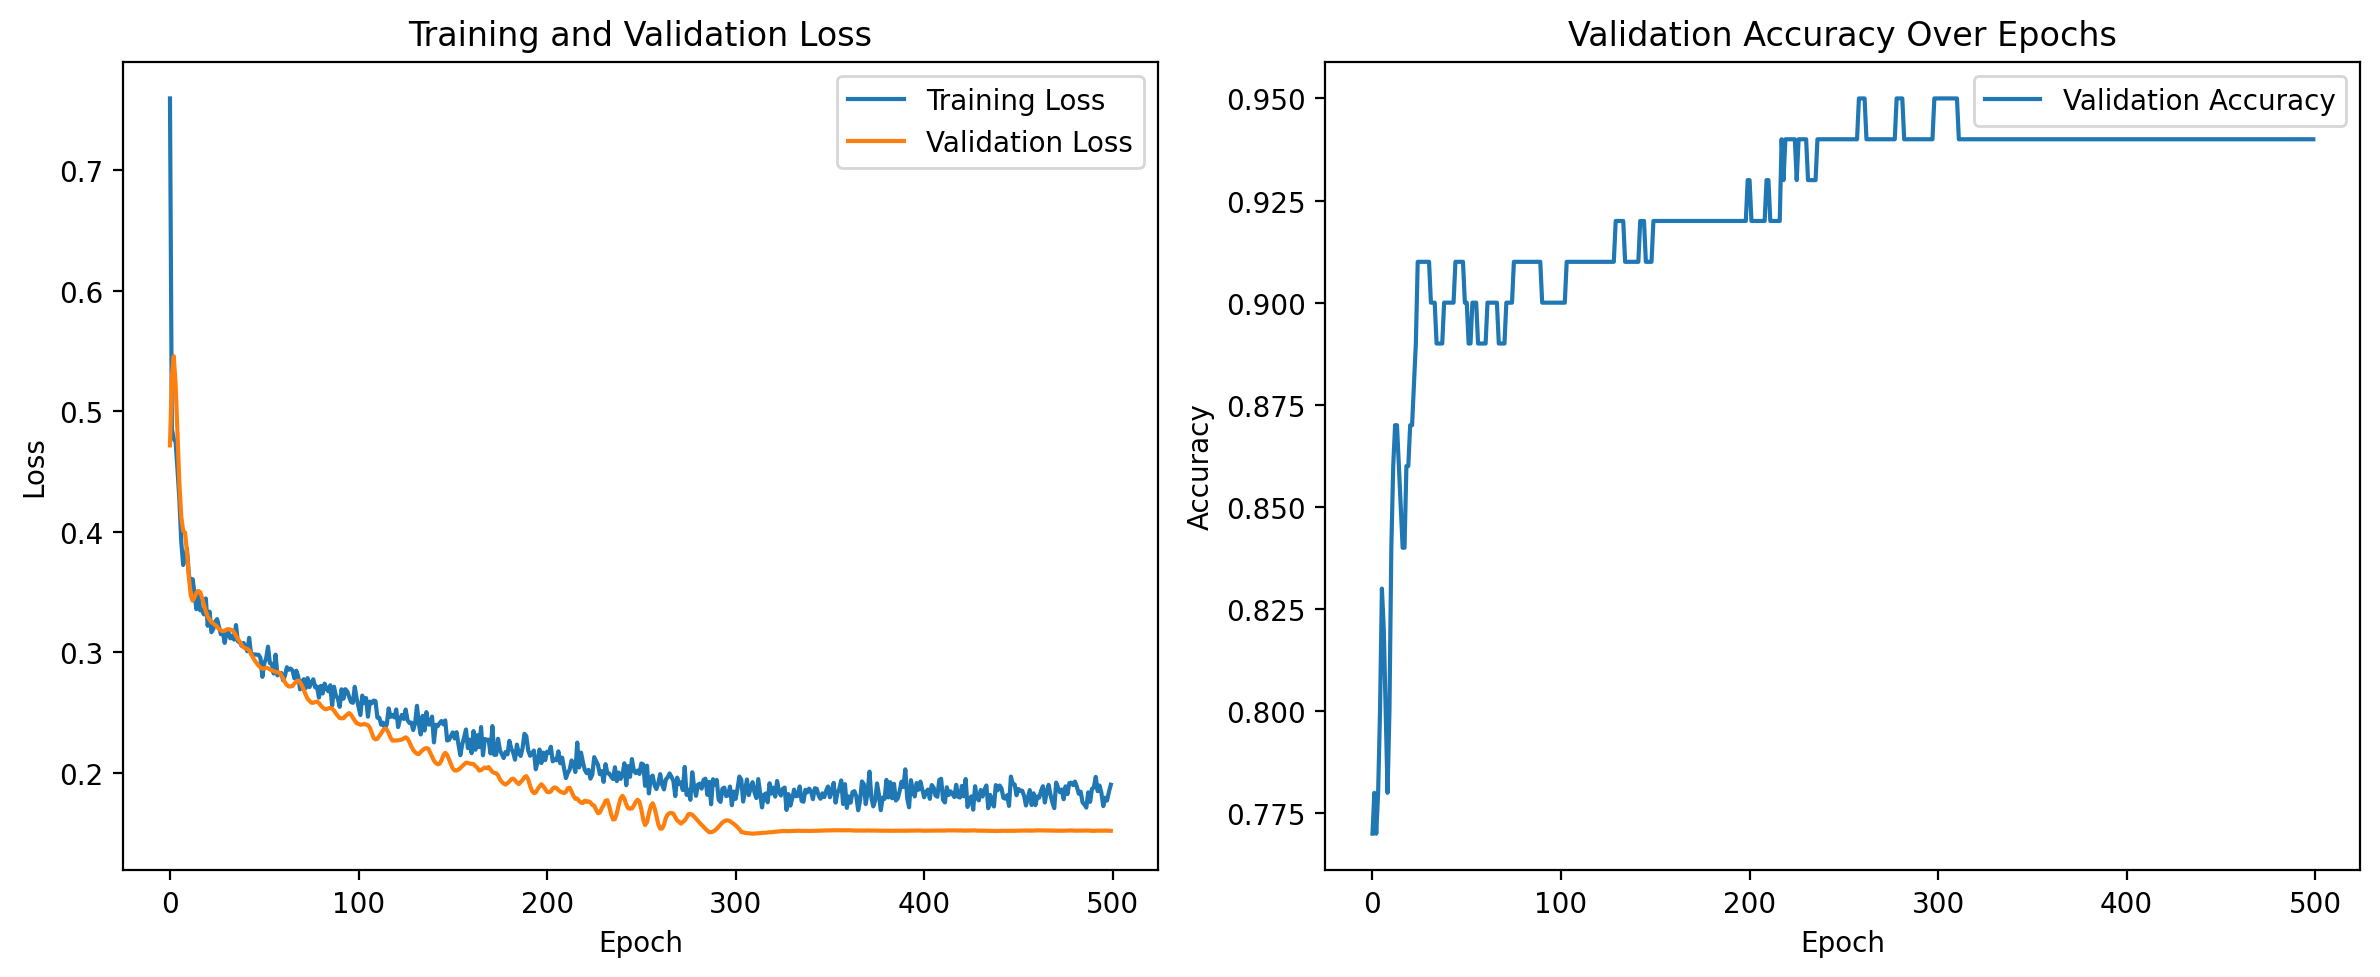

In [30]:
# Cell 11: Training History Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history['train_loss'], label='Training Loss')
plt.plot(final_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(final_history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Over Epochs')
plt.tight_layout()
plt.show()

In [31]:
# Cell 12: Rule Extraction
extract_and_print_rules(final_model, selected_features, feature_ranges)


================= CLINICAL INTERPRETATION (SELECTED FEATURES) ==================

** Rule 1 **
IF
  • Insulin         is Low    (84.6±211.5) [Weight: 0.20]
  • Glucose         is Low    (19.9±49.8) [Weight: 0.40]
  • Age             is Low    (27.0±15.0) [Weight: 0.10]
  • BMI             is Low    (6.7±16.8) [Weight: 0.25]
  • DiabetesPedigreeFunction is Low    (0.3±0.6) [Weight: 0.05]

THEN → LOW diabetes risk (Healthy) ✓✓✓
  Composite Risk Score: 0.100/1.0

** Rule 2 **
IF
  • Insulin         is Medium (107.9±211.5) [Weight: 0.20]
  • Glucose         is Low    (25.4±49.8) [Weight: 0.40]
  • Age             is Low    (28.7±15.0) [Weight: 0.10]
  • BMI             is Low    (8.6±16.8) [Weight: 0.25]
  • DiabetesPedigreeFunction is Low    (0.4±0.6) [Weight: 0.05]

THEN → LOW diabetes risk (Healthy) ✓✓✓
  Composite Risk Score: 0.128/1.0

** Rule 3 **
IF
  • Insulin         is Medium (131.3±211.5) [Weight: 0.20]
  • Glucose         is Low    (30.9±49.8) [Weight: 0.40]
  • Age           

In [32]:
X_normalized

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0       0.639947  0.864625       0.149641       0.907270  0.311604  0.169483   
1      -0.844885 -1.204727      -0.160546       0.530902 -0.440843 -0.848549   
2       1.233880  2.014265      -0.263941      -1.288212  0.311604 -1.328478   
3      -0.844885 -1.073339      -0.160546       0.154533 -0.536303 -0.630399   
4      -1.141852  0.503310      -1.504687       0.907270  0.294758  1.551096   
..           ...       ...            ...            ...       ...       ...   
763     1.827813 -0.679177       0.356432       1.722735  0.429525  0.067679   
764    -0.547919  0.010607       0.046245       0.405445 -0.440843  0.634868   
765     0.342981 -0.022240       0.149641       0.154533 -0.334153 -0.906722   
766    -0.844885  0.141994      -0.470732      -1.288212  0.311604 -0.339533   
767    -0.844885 -0.941952       0.046245       0.656358 -0.440843 -0.295903   

     DiabetesPedigreeFunction       Age  
0                    0.468492  1.425995  
1                   -0.365061 -0.190672  
2                    0.604397 -0.105584  
3                   -0.920763 -1.041549  
4                    5.484909 -0.020496  
..                        ...       ...  
763                 -0.908682  2.532136  
764                 -0.398282 -0.531023  
765                 -0.685193 -0.275760  
766                 -0.371101  1.170732  
767                 -0.473785 -0.871374  

[768 rows x 8 columns]

In [33]:
feature_ranges = {col: (X_normalized[col].min(), X_normalized[col].max()) for col in selected_features}
feature_ranges

{'Insulin': (-1.4347468683429125, 7.909072271913734),
 'Glucose': (-2.551447415173168, 2.5398141562063064),
 'Age': (-1.0415494364835023, 4.063715751598595),
 'BMI': (-2.0701862333241516, 5.041489186969584),
 'DiabetesPedigreeFunction': (-1.1895531764897842, 5.88356476587794)}